### General settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from scipy import stats

# for 3d plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

# for animation
from matplotlib.animation import FuncAnimation

In [2]:
!git clone https://github.com/SeanNobel/steinmetz_utils.git
from steinmetz_utils import steinmetz_utils

Cloning into 'steinmetz_utils'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 2), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [3]:
## define functions

def compute_acc(X, y, model):
  y_pred = model.predict(X)
  acc = np.mean(y_pred == y)
  return acc


def plot_by_pretrial_feedback(s, feedback_type, title = None, normalize = False, save=False):
    '''

    :param s: data of spike trians: (neurons * trials * time bins)
    :param feedback_type: an array made up of 1s & -1s. 1 for reward and -1 for penalty.
    :param title: the title of the plot generated. e.g., the name of brain region.
    :param normalize：whether normalize the spike data by trials and neurons.

    :return: plot (made by pyplot)

    '''

    isRew = feedback_type == 1
    isPen = feedback_type == -1

    lastIsRew = isRew[:-1]
    lastIsPen = isPen[:-1]

    if normalize:
        for i in range(s.shape[2]):
            s[:,:,i] = (s[:,:,i] - np.mean(s,2)) / np.std(s,2)

    s = s[:,1:,:]
    s_lastIsRew = s[:,lastIsRew,:]
    s_lastIsPen = s[:,lastIsPen,:]

    err_lastIsRew = np.std(np.mean(s_lastIsRew,0),0) / np.sqrt(s_lastIsRew.shape[1]-1)
    err_lastIsPen = np.std(np.mean(s_lastIsPen,0),0) / np.sqrt(s_lastIsPen.shape[1]-1)

    # draw the plot
    x = list(range(0,s.shape[2],1))
    plt.figure()
    myfig = plt.gcf()

    plt.errorbar(x, np.mean(s_lastIsRew, (0,1)), yerr=err_lastIsRew, label='Post Reward')
    plt.errorbar(x, np.mean(s_lastIsPen, (0,1)), yerr=err_lastIsPen, label='Post Penalty')

    plt.title(title)
    plt.legend()
    plt.show()

    if save:
      myfig.savefig('./'+ str(title))

def plot_by_curr_corr(s, corr, title = None, normalize = False, save=False):
    '''

    :param s: data of spike trians: (neurons * trials * time bins)
    :param corr: an array made up of 1s & -1s. 1 for correct and -1 for error
    :param title: the title of the plot generated. e.g., the name of brain region.
    :param normalize：whether normalize the spike data by trials and neurons.

    :return: plot (made by pyplot)

    '''

    isCorr = corr == 1
    isErr = corr == -1

    if normalize:
        for i in range(s.shape[2]):
            s[:,:,i] = (s[:,:,i] - np.mean(s,2)) / np.std(s,2)

    s = s[:,:,:]
    s_corr = s[:,isCorr,:]
    s_err = s[:,isErr,:]

    err_corr = np.std(np.mean(s_corr,0),0) / np.sqrt(s_corr.shape[1]-1)
    err_err = np.std(np.mean(s_err,0),0) / np.sqrt(s_err.shape[1]-1)

    # draw the plot
    x = list(range(0,s.shape[2],1))
    plt.figure()
    myfig = plt.gcf()

    plt.errorbar(x, np.mean(s_corr, (0,1)), yerr=err_corr, label='Correct final')
    plt.errorbar(x, np.mean(s_err, (0,1)), yerr=err_err, label='Error final')

    plt.title(title)
    plt.legend()
    plt.show()

    if save:
      myfig.savefig('./figure/'+ str(title))

def plot_by_pretrial_resp(s, resp, title = None, normalize = False):
    '''

    :param s: data of spike trians: (neurons * trials * time bins)
    :param feedback_type: an array made up of 1s & -1s. 1 for reward and -1 for penalty.
    :param title: the title of the plot generated. e.g., the name of brain region.
    :param normalize：whether normalize the spike data by trials and neurons.

    :return: plot (made by pyplot)

    '''

    isRew = resp == 1
    isPen = resp == -1

    lastIsRew = isRew[:-1]
    lastIsPen = isPen[:-1]

    if normalize:
        for i in range(s.shape[2]):
            s[:,:,i] = (s[:,:,i] - np.mean(s,2)) / np.std(s,2)

    s = s[:,1:,:]
    s_lastIsRew = s[:,lastIsRew,:]
    s_lastIsPen = s[:,lastIsPen,:]

    err_lastIsRew = np.std(np.mean(s_lastIsRew,0),0) / np.sqrt(s_lastIsRew.shape[1]-1)
    err_lastIsPen = np.std(np.mean(s_lastIsPen,0),0) / np.sqrt(s_lastIsPen.shape[1]-1)

    # draw the plot
    x = list(range(0,s.shape[2],1))
    # plt.figure()
    # myfig = plt.gcf()

    plt.errorbar(x, np.mean(s_lastIsRew, (0,1)), yerr=err_lastIsRew, label='Post Left')
    plt.errorbar(x, np.mean(s_lastIsPen, (0,1)), yerr=err_lastIsPen, label='Post Right')

    plt.title(title)
    plt.legend()
    plt.show()

### Neural Model

In [4]:
def neuronModel3D(s, y, dim_left = 'time',penalty='l2', C=1, cv=16):
    # s: (neuron * trial * time) format
    print('s shape =', s.shape)

    if dim_left == 'time':
      X = np.average(s, 0)
      print('X dim (time left):', X.shape)
    elif dim_left == 'neuron':
      X = np.average(s, 2)
      X = np.transpose(X)
      print('X dim (neuron left):', X.shape)
    else:
      print('Please enter "time" or "neuron" for the parameter: dim_left (set as "time" by default)')

    # add 1s line
    dim = X.shape[0]
    X = np.concatenate((np.ones(dim).reshape(dim,1),X), axis=1)
    print('add "1"s ->',X.shape)

    # fit GLM with regularization
    if penalty == 'l2':
        model = LogisticRegression(penalty='l2',C=C,max_iter=5000)
    elif penalty == 'l1':
        model = LogisticRegression(penalty='l1',C=C,max_iter=5000,solver='saga')
    else:
        model = LogisticRegression(penalty='none', max_iter=5000)

    model.fit(X,y)

    ori_acc = compute_acc(X, y, model) # a single number
    ori_cvd = cross_val_score(model, X, y, cv=cv) # an array (cv,)

    per = np.random.permutation(X.shape[0])
    X_scrambled = X[per,:]
    model.fit(X_scrambled, y)
    scrambled_acc = compute_acc(X_scrambled, y, model)
    scrambled_cvd = cross_val_score(model, X_scrambled, y, cv=cv)

    cvdMat = np.concatenate((ori_cvd.reshape(cv, 1), scrambled_cvd.reshape(cv, 1)), axis=1)

    return ori_acc,  scrambled_acc, cvdMat


## due to frequency issue, use boot strap.
def boot_strap(X, reference, each = 100): # generate new set of data
    
    idx_postRew = reference == 1
    idx_postPen = reference == -1

    X_postRew = X[idx_postRew,:]
    row_postRew = X_postRew.shape[0]
    row_postRew_choice = np.random.choice(row_postRew, each, replace=True)
    X_postRew_sample = X_postRew[row_postRew_choice,:]

    X_postPen = X[idx_postPen,:]
    row_postPen = X_postPen.shape[0]
    row_postPen_choice = np.random.choice(row_postPen, each, replace=True)
    X_postPen_sample = X_postPen[row_postPen_choice,:]

    X_new = np.concatenate((X_postRew_sample, X_postPen_sample), axis = 0)
    y_new = np.concatenate((np.ones(each), -1*np.ones(each)),axis=0)

    return X_new, y_new


def neuronModel3D_perm(s, y, dim_left = 'time',penalty='l2', C=1, cv=16, repeat = 16, bootStrap = False):
    # s: (neuron * trial * time) format
    print('s shape =', s.shape)

    if dim_left == 'time':
      X = np.average(s, 0)
      print('X dim (time left):', X.shape)
    elif dim_left == 'neuron':
      X = np.average(s, 2)
      X = np.transpose(X)
      print('X dim (neuron left):', X.shape)
    else:
      print('Please enter "time" or "neuron" for the parameter: dim_left (set as "time" by default)')

    # add 1s line
    dim = X.shape[0]
    X = np.concatenate((np.ones(dim).reshape(dim,1),X), axis=1)
    print('add "1"s ->',X.shape)


    # boot strap
    if bootStrap:
      X, y = boot_strap(X, y)

      print('\n', 'after boot_strap, X ->', X.shape)

    # fit GLM with regularization
    if penalty == 'l2':
        model = LogisticRegression(penalty='l2',C=C,max_iter=5000)
    elif penalty == 'l1':
        model = LogisticRegression(penalty='l1',C=C,max_iter=5000,solver='saga')
    else:
        model = LogisticRegression(penalty='none', max_iter=5000)

    model.fit(X,y)

    ori_acc = compute_acc(X, y, model) # a single number
    ori_cvd = cross_val_score(model, X, y, cv=cv) # an array (cv,)

    # do permutation
    scrambled_acc_collect = np.zeros(repeat)
    scrambled_cvd_collect = np.zeros(shape=(repeat, cv))

    for i in range(repeat):
        print('running epoch', str(i))
        per = np.random.permutation(X.shape[0])
        X_scrambled = X[per,:]
        model.fit(X_scrambled, y)

        scrambled_acc = compute_acc(X_scrambled, y, model)
        scrambled_acc_collect[i] = scrambled_acc

        scrambled_cvd = cross_val_score(model, X_scrambled, y, cv=cv)
        scrambled_cvd_collect[i,:] = scrambled_cvd

    print('finished')

    return ori_acc, np.mean(ori_cvd), scrambled_acc_collect, scrambled_cvd_collect
  
  

### Func for pca visualization

In [5]:
# utile function for pca visualization  

def plot_3d(X1,X2,cmap1='winter',cmap2='copper',label1=None,label2=None):
    fig = plt.figure(figsize=(9,6))
    ax = Axes3D(fig)

    cm1 = plt.get_cmap(cmap1)
    cm2 = plt.get_cmap(cmap2)
    
    cNorm = matplotlib.colors.Normalize(vmin=0, vmax=X1.shape[0])
    scalarMap1 = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm1)
    scalarMap2 = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm2)

    ax.scatter3D(X1[:,0], X1[:,1], X1[:,2],
          c=list(range(X1.shape[0])),
          cmap=plt.cm.get_cmap(cmap1),
          label = label1)
    
    ax.scatter3D(X2[:,0], X2[:,1], X2[:,2],
      c=list(range(X2.shape[0])),
      cmap=plt.cm.get_cmap(cmap2),
      label = label2)
    

    ax.legend()
    fig.colorbar(scalarMap1)
    fig.colorbar(scalarMap2)

def plot_3d_class(X1,X2,cmap1='winter',cmap2='copper',label1=None,label2=None):
    fig = plt.figure(figsize=(9,6))
    ax = Axes3D(fig)

    ax.scatter3D(X1[:,0], X1[:,1], X1[:,2],
          label = label1)
    
    ax.scatter3D(X2[:,0], X2[:,1], X2[:,2],
      label = label2)
  
    ax.legend()

def plot_2d_project(X1,X2,dim = (0,1),cmap1='winter',cmap2='copper',label1=None,label2=None,title=None):
  
    fig = plt.figure(figsize=(12,8))
    cm1 = plt.get_cmap(cmap1)
    cm2 = plt.get_cmap(cmap2)
    
    cNorm = matplotlib.colors.Normalize(vmin=0, vmax=X1.shape[0])
    scalarMap1 = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm1)
    scalarMap2 = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm2)

    plt.scatter(X1[:,dim[0]], X1[:,dim[1]],
          c=list(range(X1.shape[0])),
          cmap=plt.cm.get_cmap(cmap1),
          label = label1)
    
    plt.scatter(X2[:,dim[0]], X2[:,dim[1]],
      c=list(range(X2.shape[0])),
      cmap=plt.cm.get_cmap(cmap2),
      label = label2)
    

    # plt.legend()
    plt.title(title)
    fig.colorbar(scalarMap1)
    fig.colorbar(scalarMap2)

def plot_2d_project_line(X1,X2,dim = (0,1),cmap1='winter',cmap2='copper',label1=None,label2=None,title=None):
  
    fig = plt.figure(figsize=(12,8))

    plt.plot(X1[:,dim[0]], X1[:,dim[1]],
          label = label1)
    
    plt.plot(X2[:,dim[0]], X2[:,dim[1]],
      label = label2)
    

    # plt.legend()
    plt.title(title)

def plot_2d_class(X1,X2,dim=(0,1),cmap1='winter',cmap2='copper',label1=None,label2=None,title=None):
    fig = plt.figure(figsize=(9,6))

    plt.scatter(X1[:,dim[0]], X1[:,dim[1]],
          label = label1)
    
    plt.scatter(X2[:,dim[0]], X2[:,dim[1]],
      label = label2)
  
    plt.legend()
    plt.title(title)

### Func for Animation production 

In [6]:
# animation production

def anime(X, dim=(0, 1), title=None, color='blue'):
    plt.ion()
    plt.title(title)

    axis1 = X[:, dim[0]]
    axis2 = X[:, dim[1]]

    plt.axis([min(axis1)-0.1,max(axis1)+0.1,min(axis2)-0.1,max(axis2)+0.1])

    xs = axis1[:2]
    ys = axis2[:2]

    for i in range(X.shape[0] - 2):
        x_new = axis1[i + 2]
        y_new = axis2[i + 2]

        xs[0] = xs[1]
        ys[0] = ys[1]
        xs[1] = x_new
        ys[1] = y_new

        plt.scatter(xs, ys, color=color)
        plt.pause(0.1)

    plt.pause(5)
    plt.close()

def anime2(X1,X2,label1,label2,
           dim=(0, 1), title=None,
           color1='pink', color2 = 'purple'):
    plt.ion()
    plt.title(title)

    X1_x = X1[:, dim[0]]
    X1_y = X1[:, dim[1]]

    X2_x = X2[:, dim[0]]
    X2_y = X2[:, dim[1]]

    minx = min(min(X1_x),min(X2_x))
    maxx = max(max(X1_x),max(X2_x))
    miny = min(min(X1_y),min(X2_y))
    maxy = max(max(X1_y),max(X2_y))

    plt.axis([minx-0.1,maxx+0.1,miny-0.1,maxy+0.1])

    x1s = X1_x[:2]
    y1s = X1_y[:2]

    x2s = X2_x[:2]
    y2s = X2_y[:2]

    for i in range(X1.shape[0] - 2):
        x1_new = X1_x[i + 2]
        y1_new = X1_y[i + 2]
        x2_new = X2_x[i + 2]
        y2_new = X2_y[i + 2]

        x1s[0] = x1s[1]
        y1s[0] = y1s[1]
        x1s[1] = x1_new
        y1s[1] = y1_new

        x2s[0] = x2s[1]
        y2s[0] = y2s[1]
        x2s[1] = x2_new
        y2s[1] = y2_new

        plt.scatter(x1s, y1s, color=color1, label=label1)
        plt.scatter(x2s, y2s, color=color2, label=label2)

        if i==0:
            plt.legend()
        plt.pause(0.1)

    plt.pause(5)
    plt.close()


In [7]:
#  Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True


### Formal code

In [8]:
# Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

# Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [9]:
# data exploration - session 7
# 4 11 12 21 24 26 35 38 both contain PL & MOs
dat = alldat[0]

gocue = dat['gocue']
np.min(gocue) # 0.40...

spks = dat['spks'][:,:,:90] # juest before gocue presentation
brain_area = dat['brain_area']
print(set(dat['brain_area']))
spks.shape

{'CA3', 'DG', 'ACA', 'VISp', 'LS', 'root', 'MOs', 'SUB'}


(734, 214, 90)

In [10]:
# visualize the spikes by brain areas
dict_by_area = steinmetz_utils.split_to_regions(spks, brain_area)
print(dict_by_area.keys())

dict_keys(['ACA', 'CA3', 'DG', 'LS', 'MOs', 'SUB', 'VISp', 'root'])


### Visualization - raw data

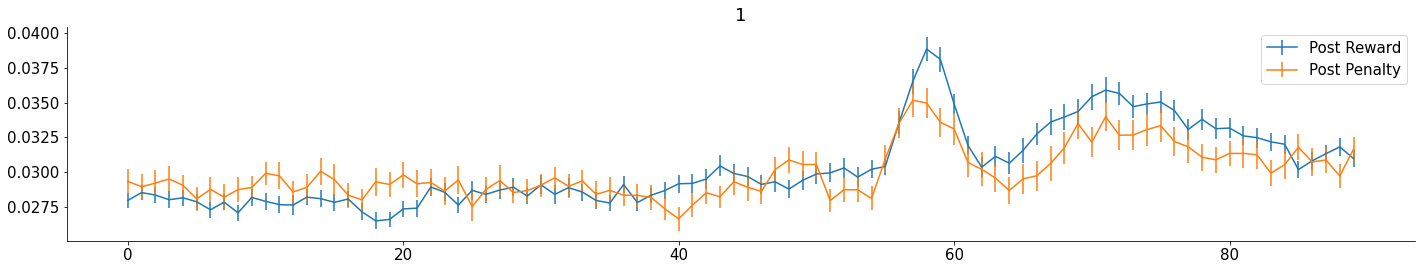

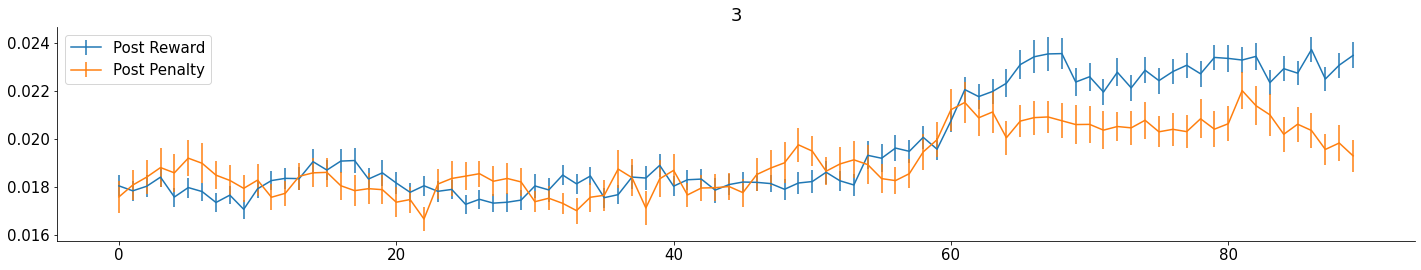

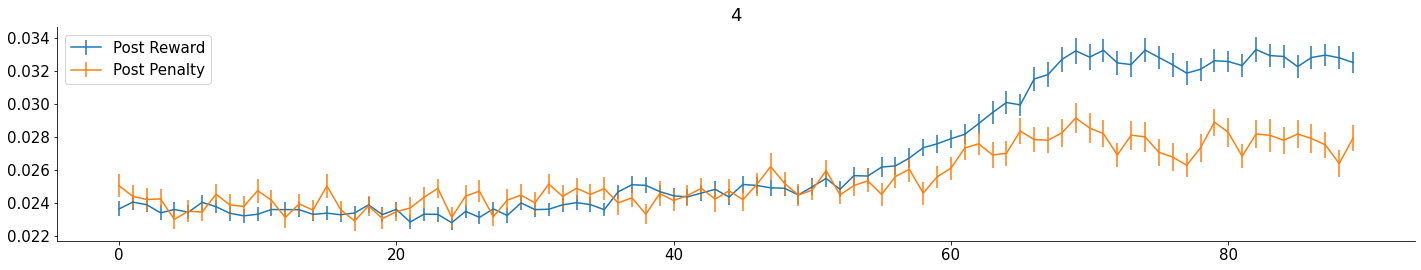

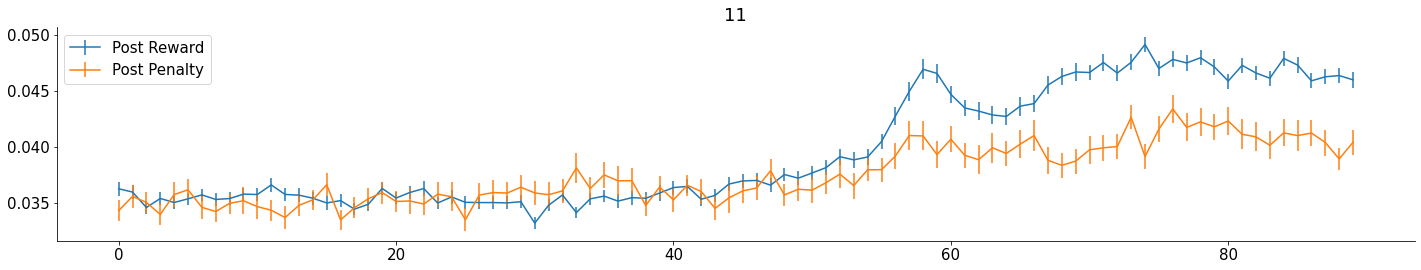

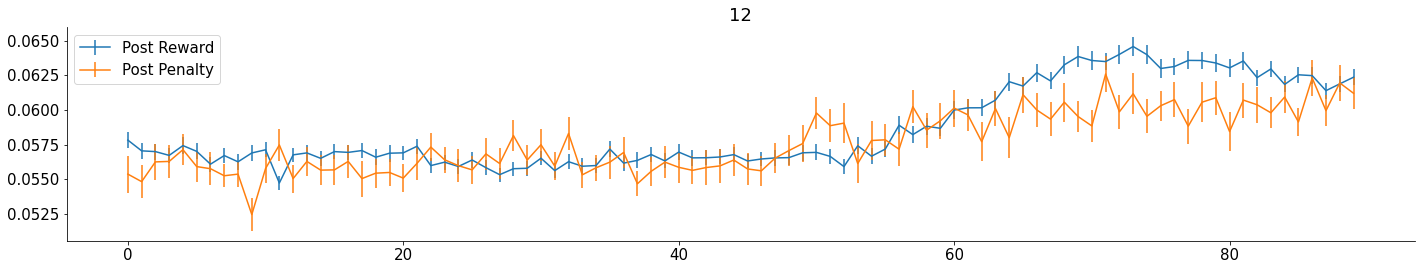

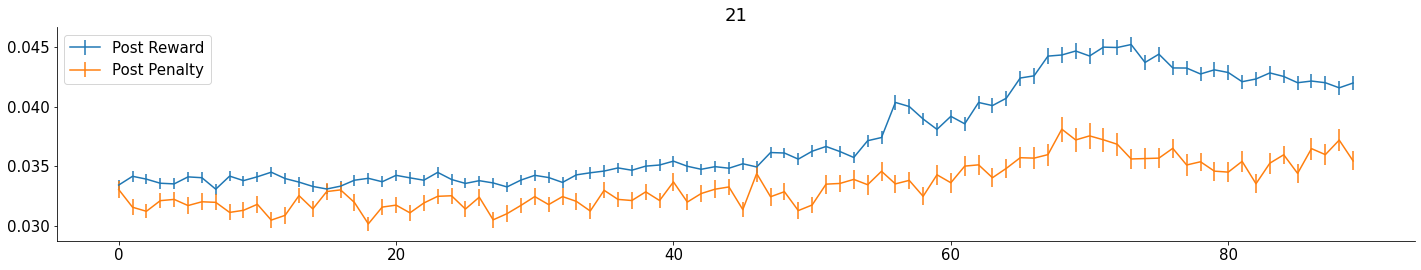

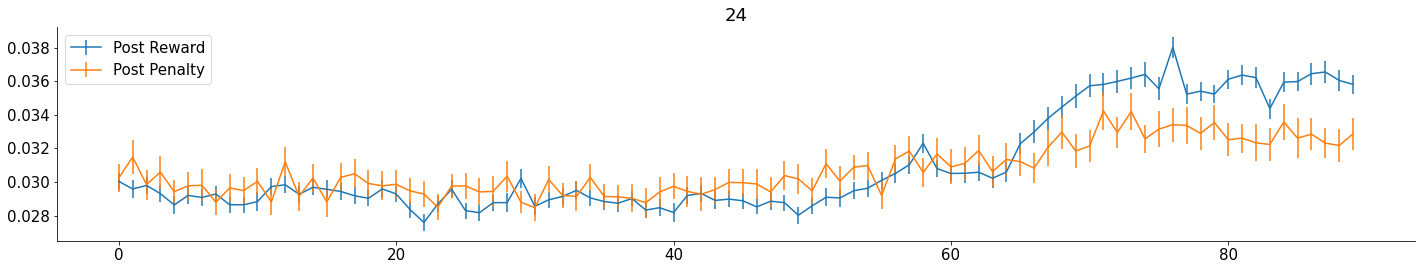

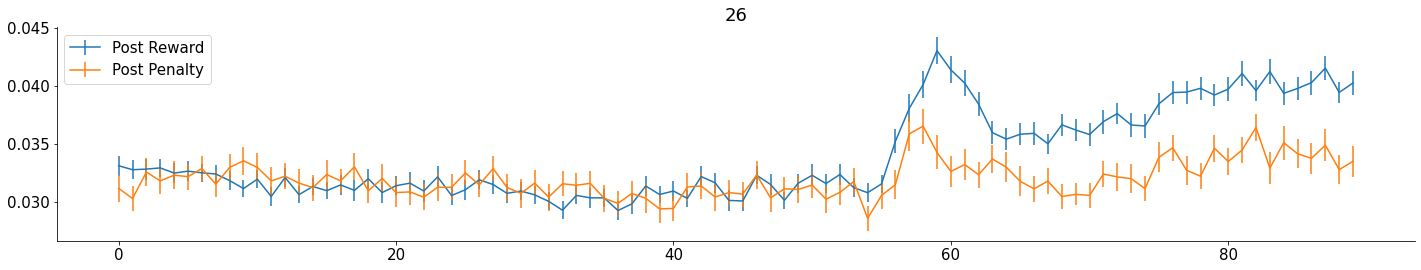

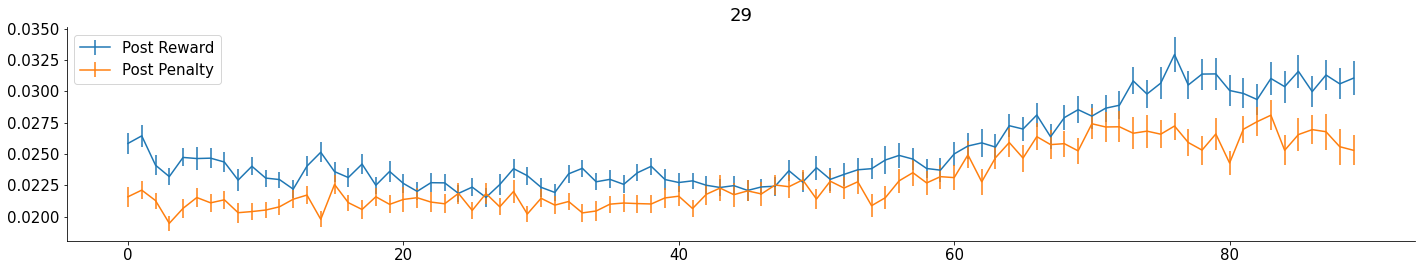

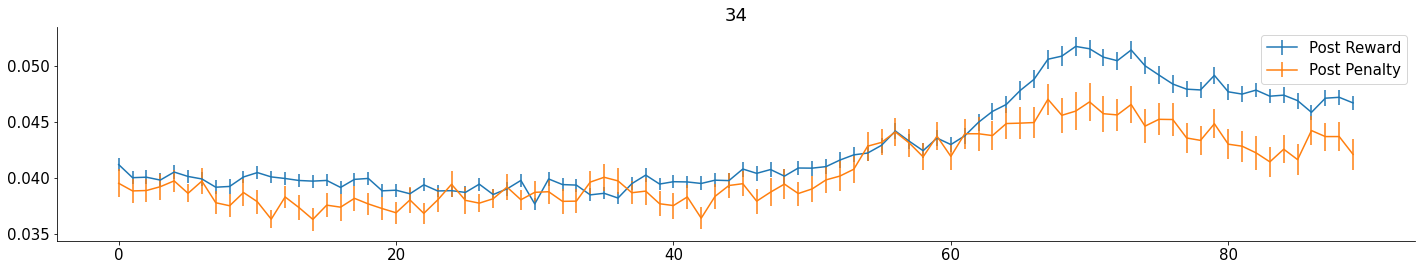

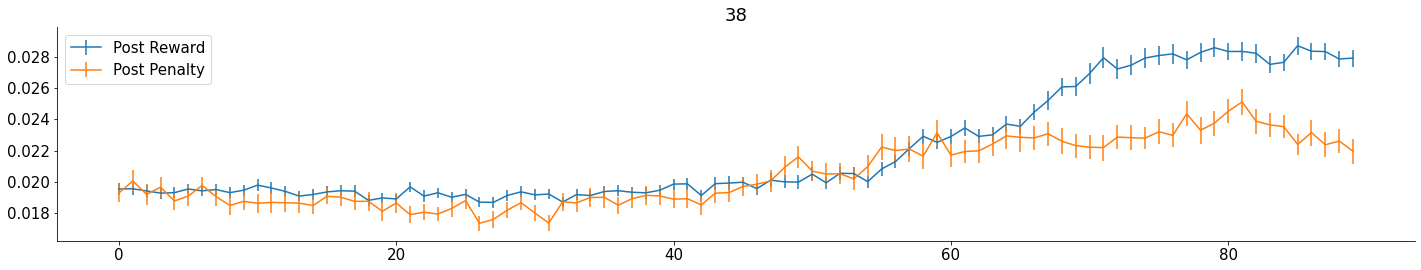

In [11]:
# 0 3 4 11 12 for ACA area
session_ACA = [1,3,4,11,12,21,24,26,29,34,38]

for i in session_ACA:
  dat = alldat[i]
  s = dat['spks'][:,:,:90]

  plot_by_pretrial_feedback(s, dat['feedback_type'], title = i, normalize = False)

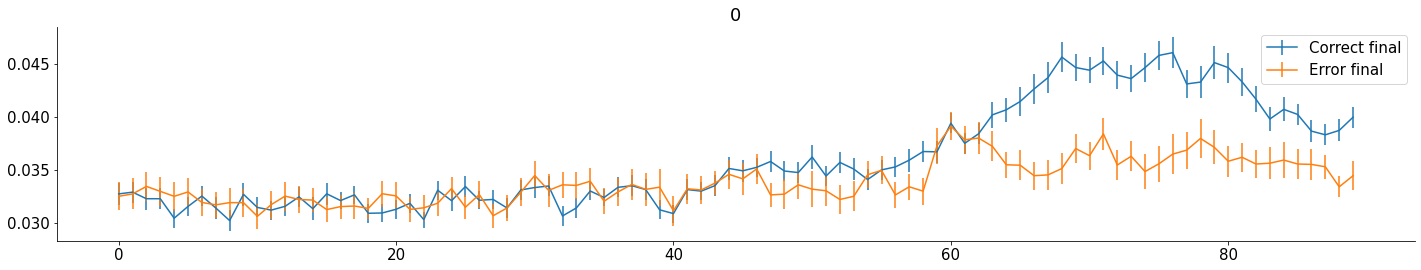

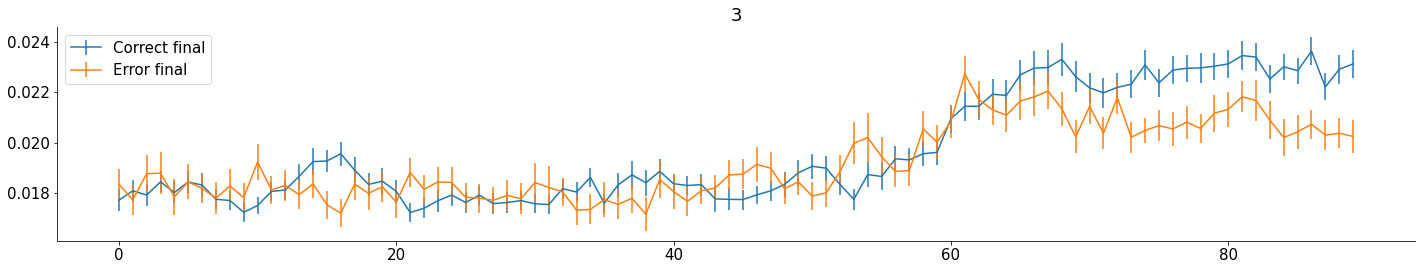

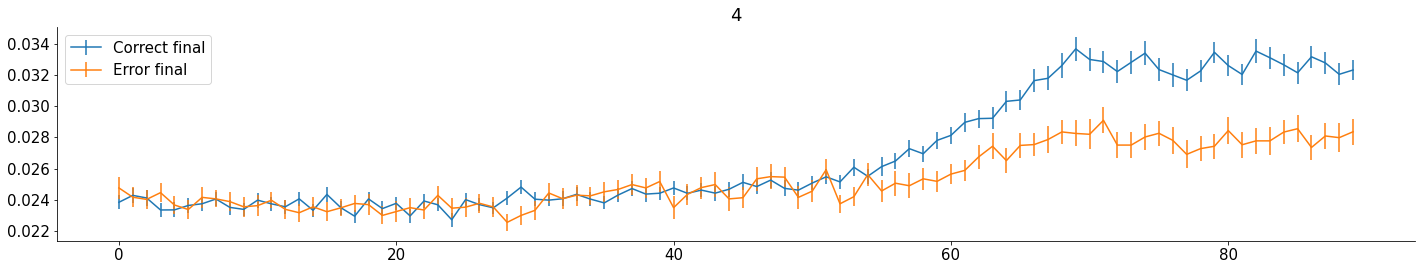

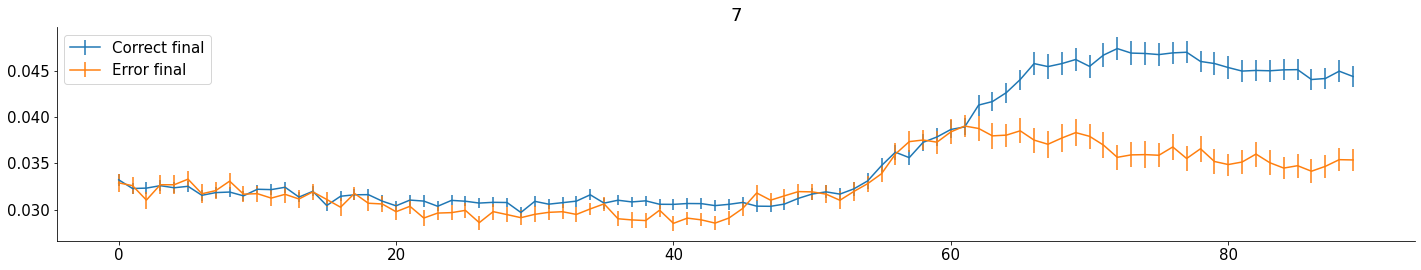

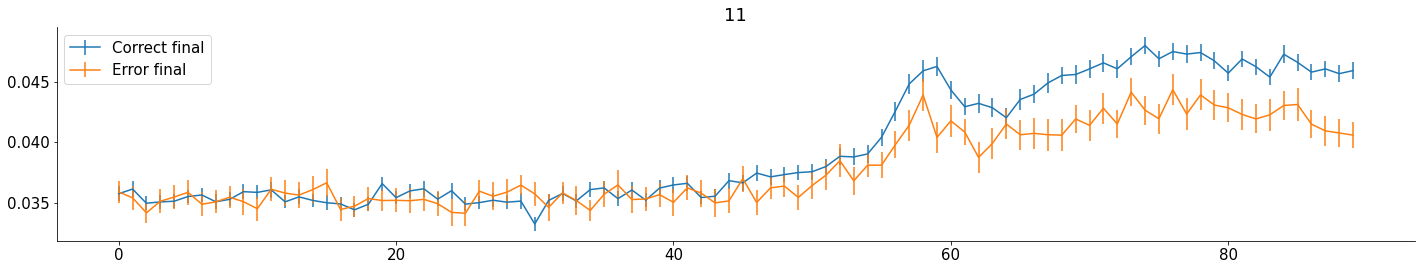

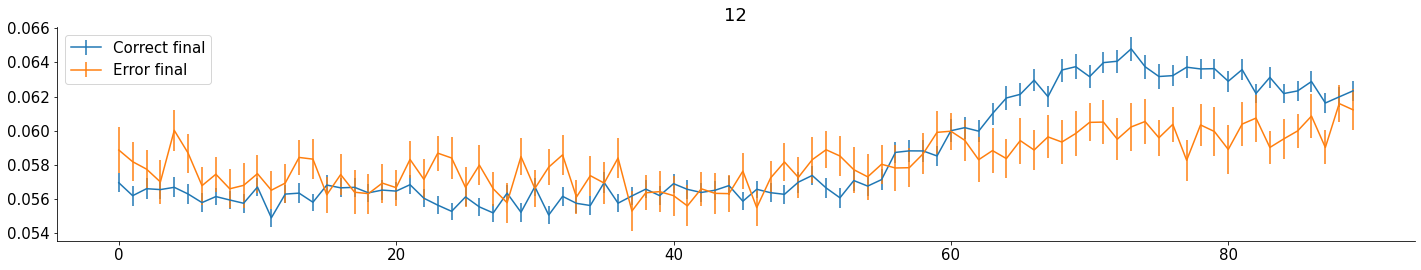

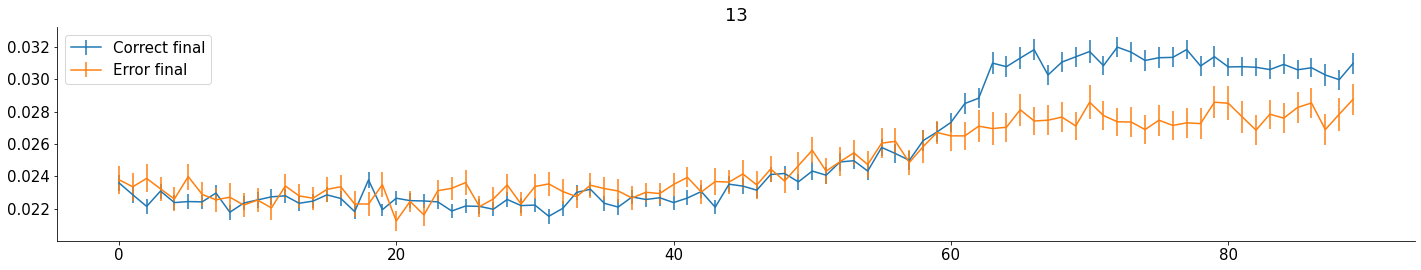

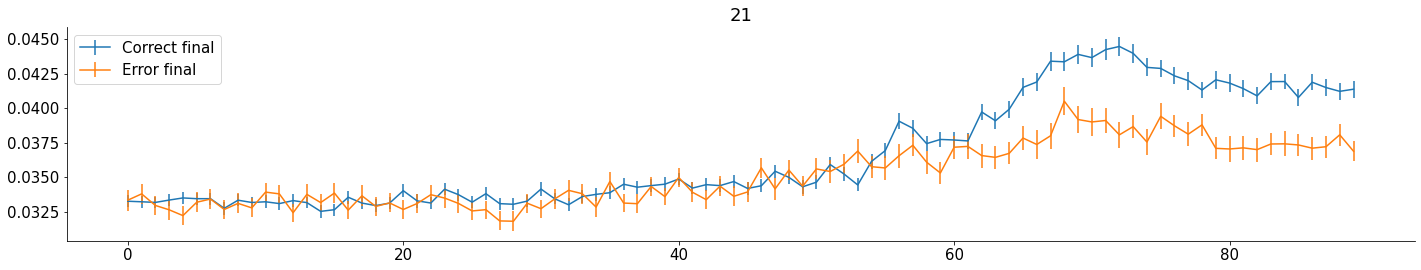

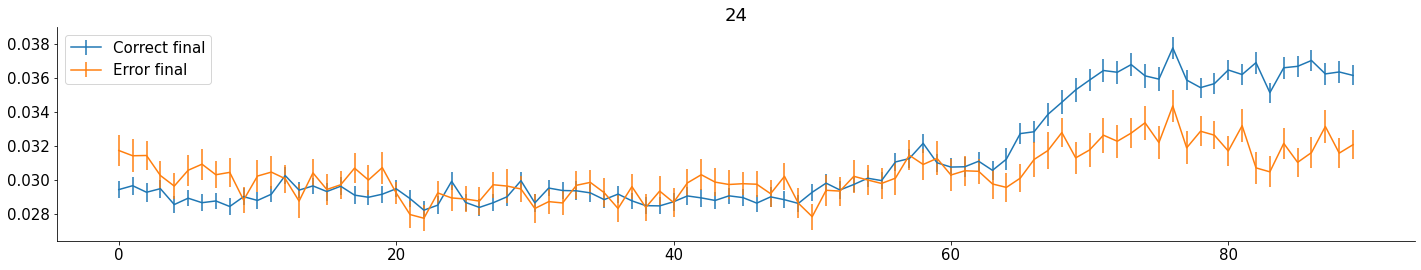

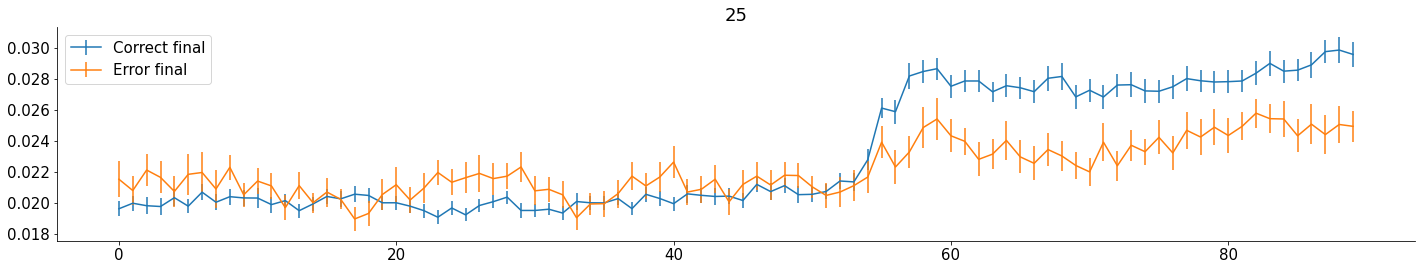

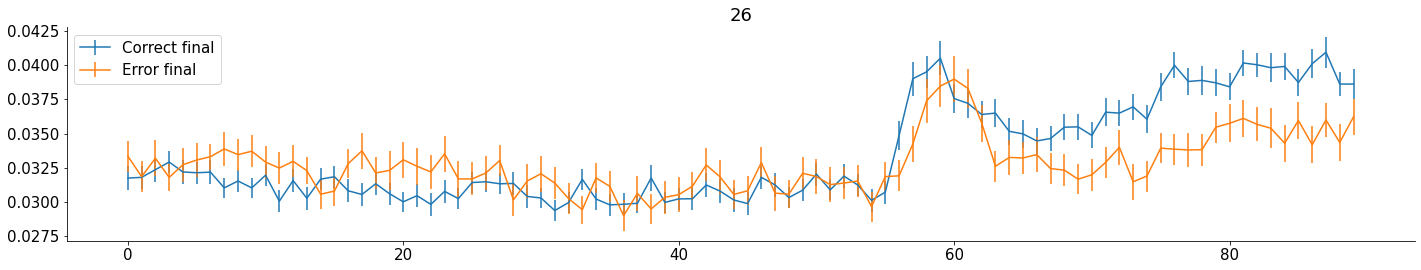

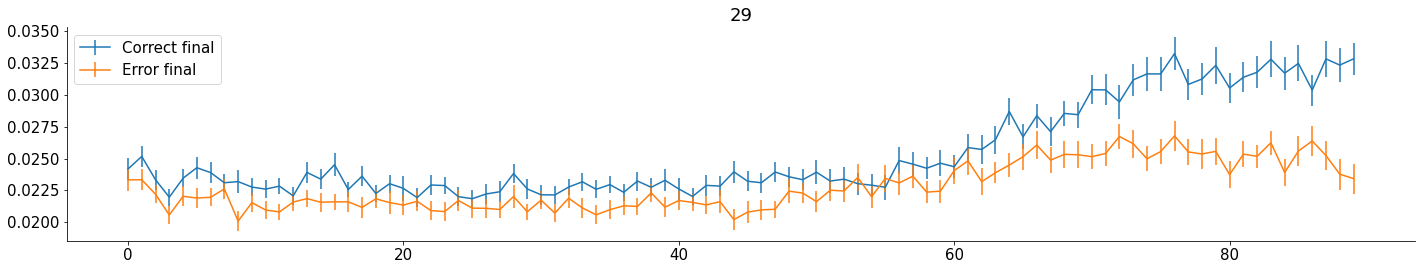

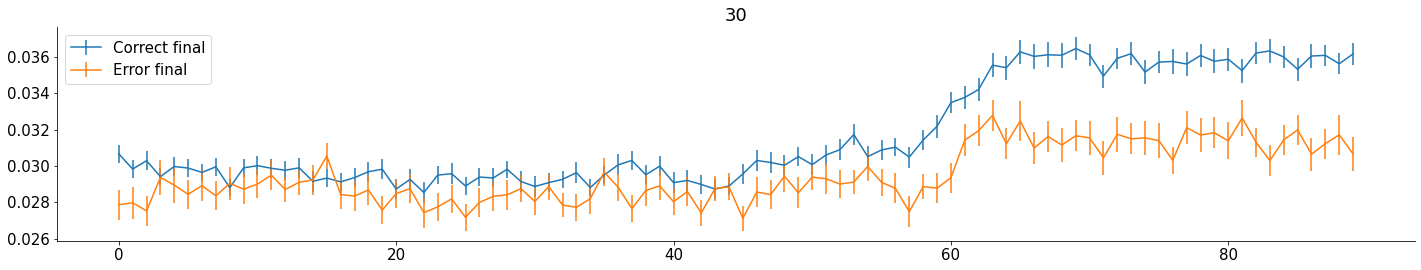

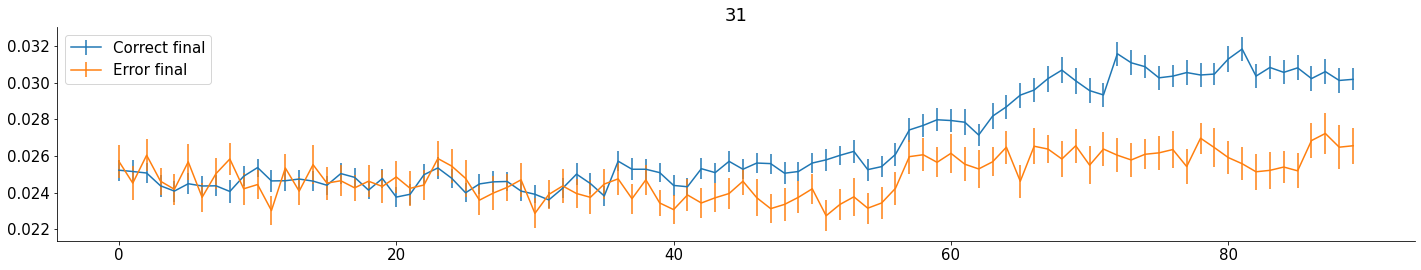

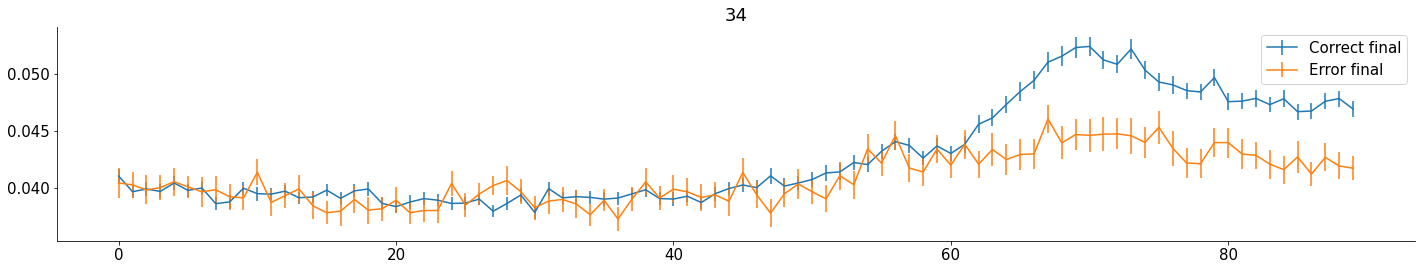

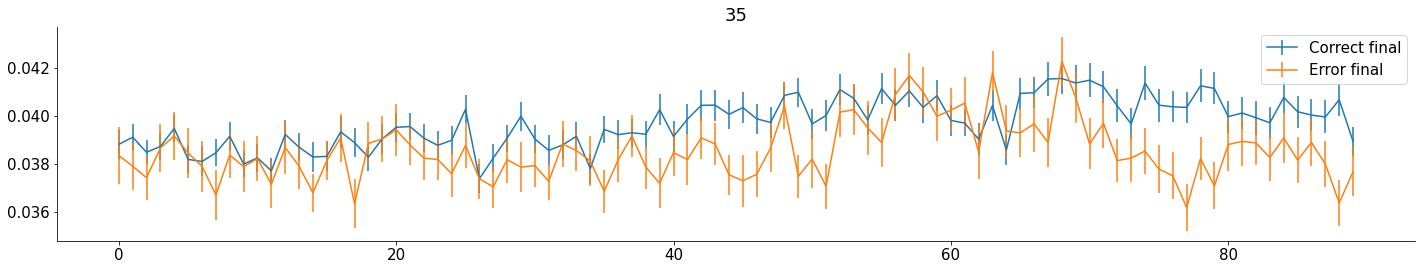

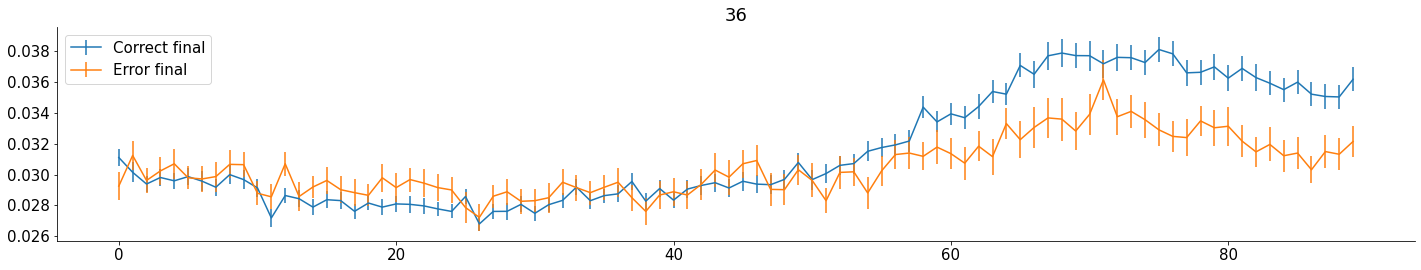

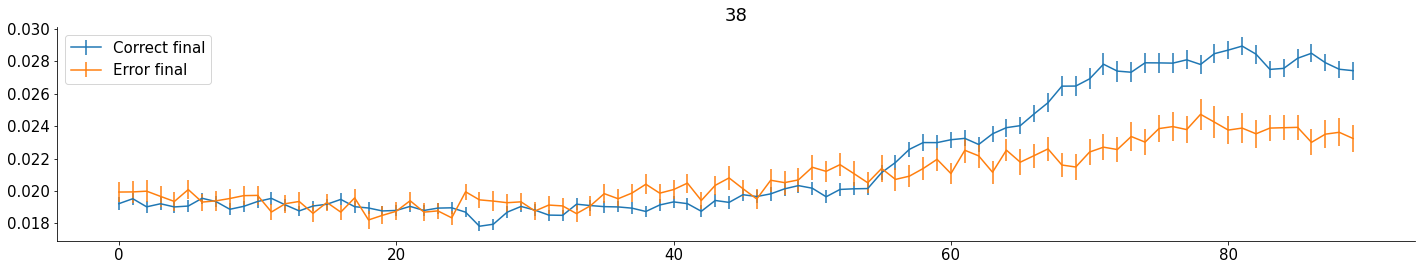

In [12]:
# 21 24 26 31 for MOs area, correctness in this trial
session_MOs = [0,3,4,7,11,12,13,21,24,25,26,29,30,31,34,35,36,38]

for i in session_MOs:
  dat = alldat[i]
  s = dat['spks'][:,:,:90]

  plot_by_curr_corr(s, dat['feedback_type'], title = i, normalize = False, save=False)

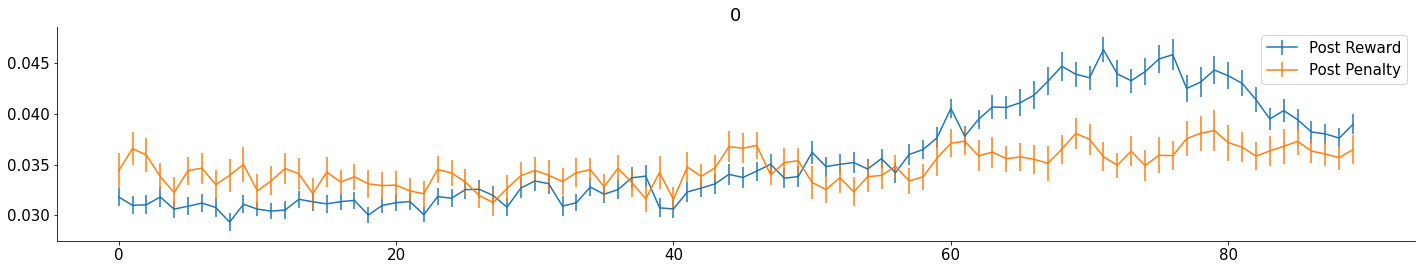

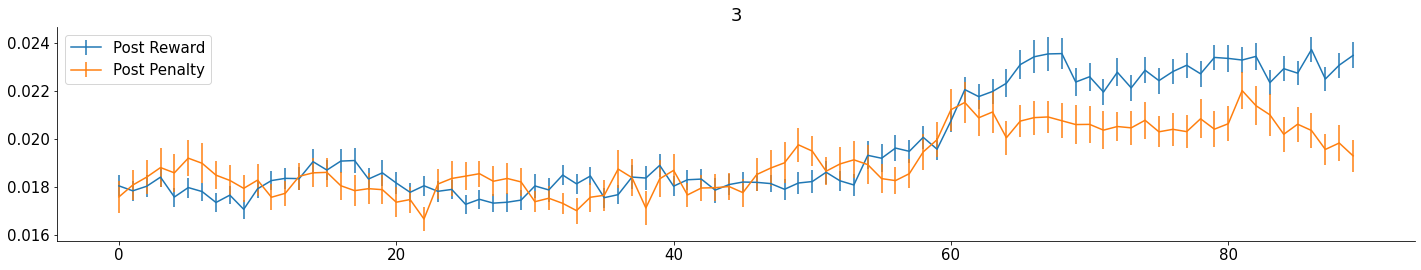

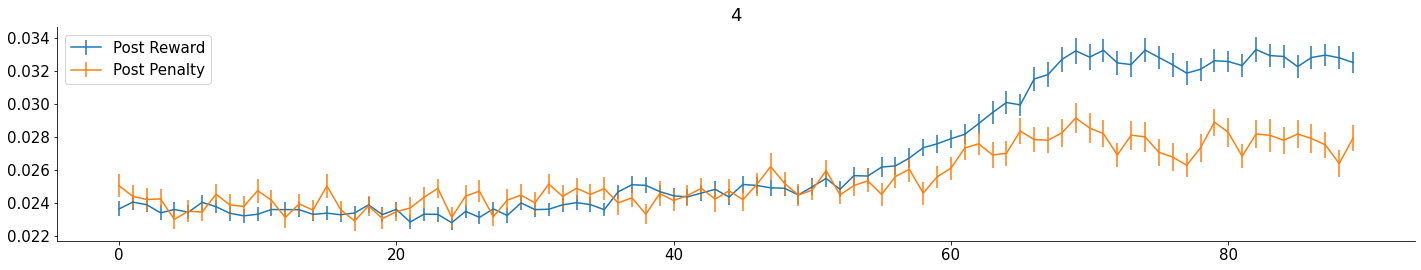

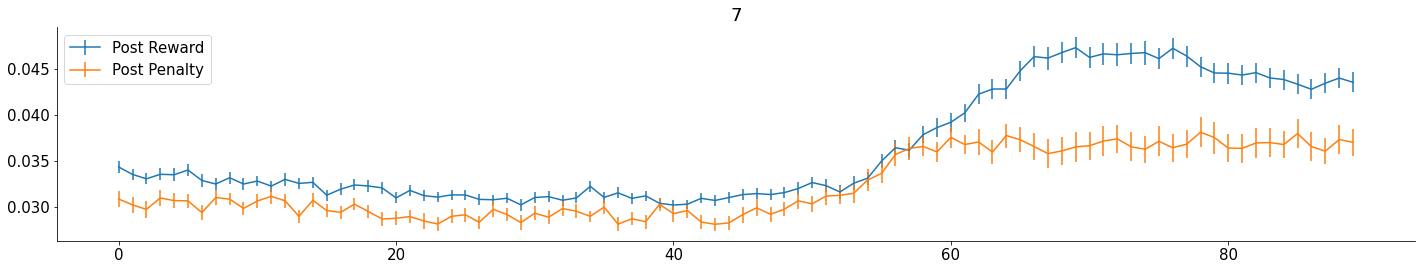

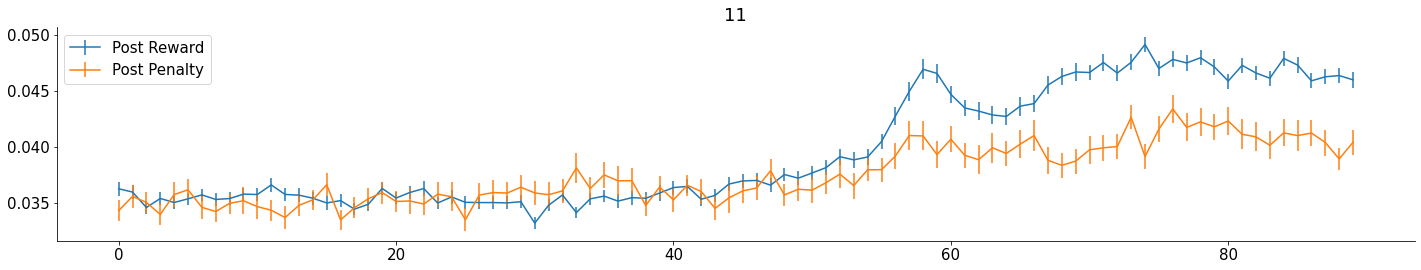

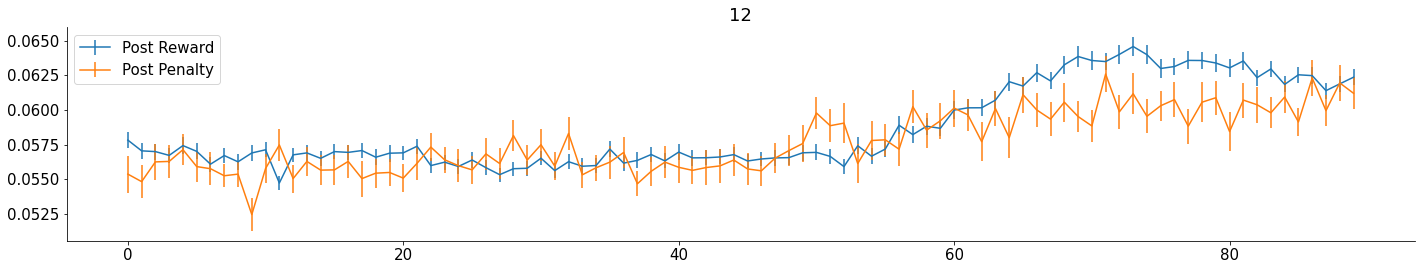

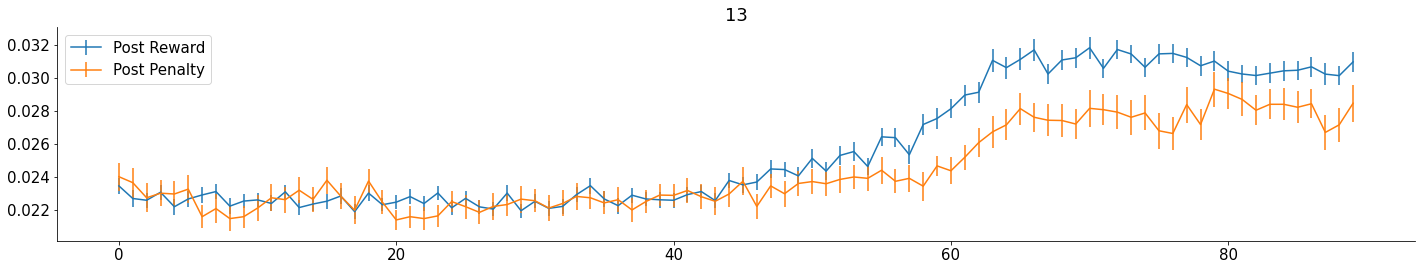

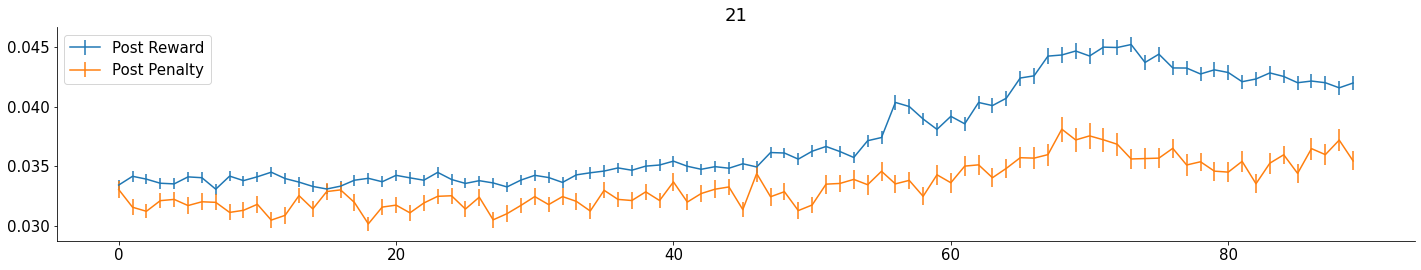

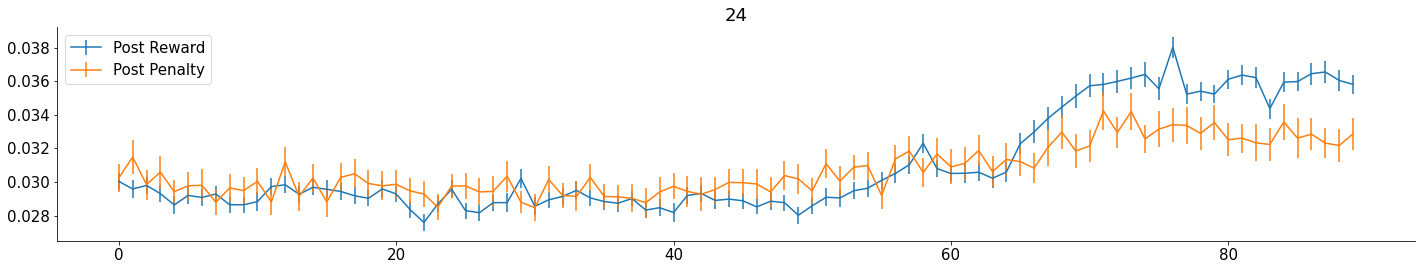

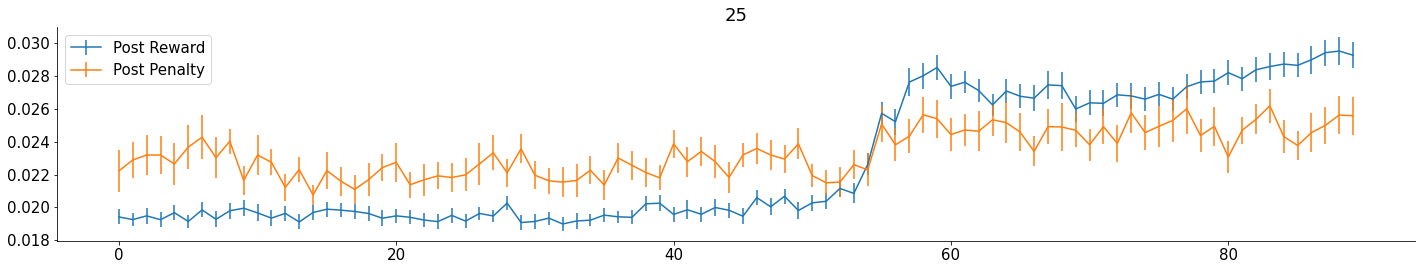

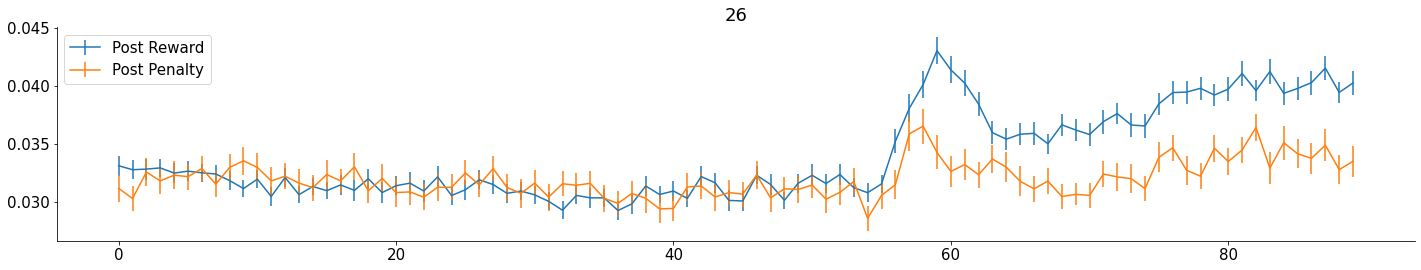

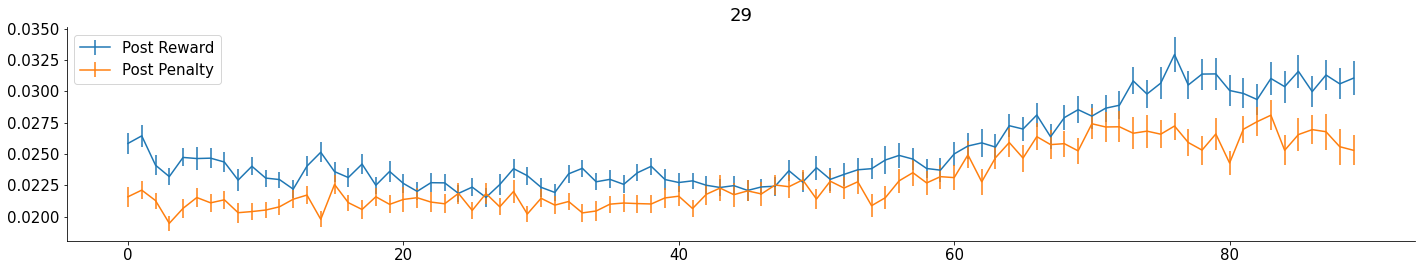

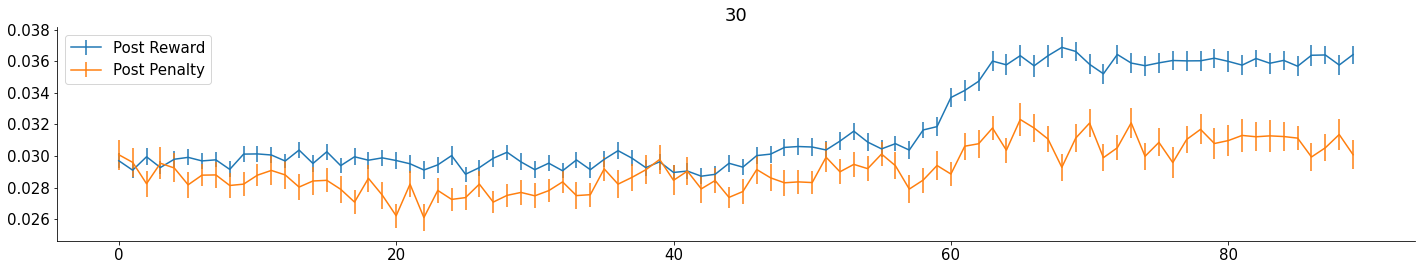

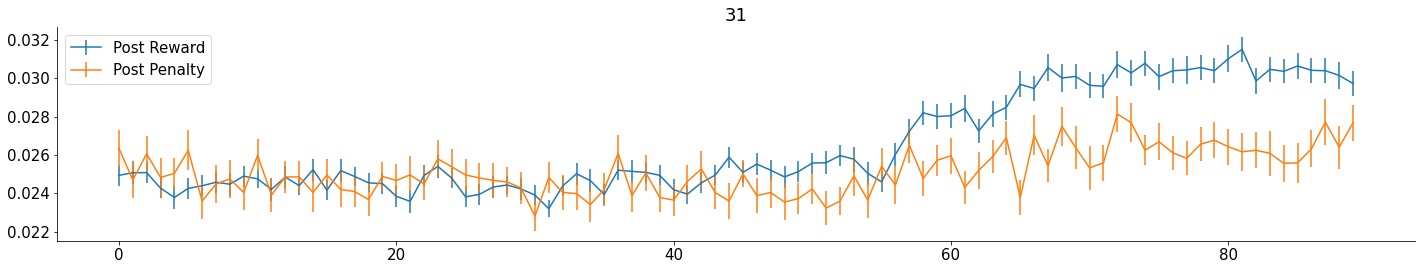

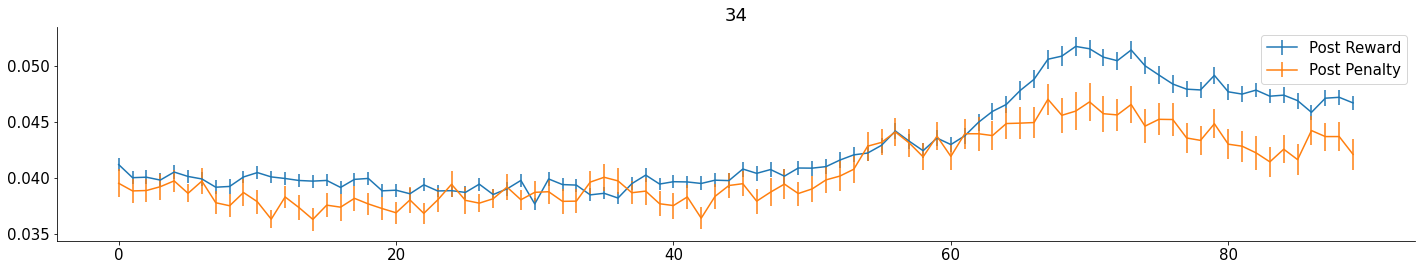

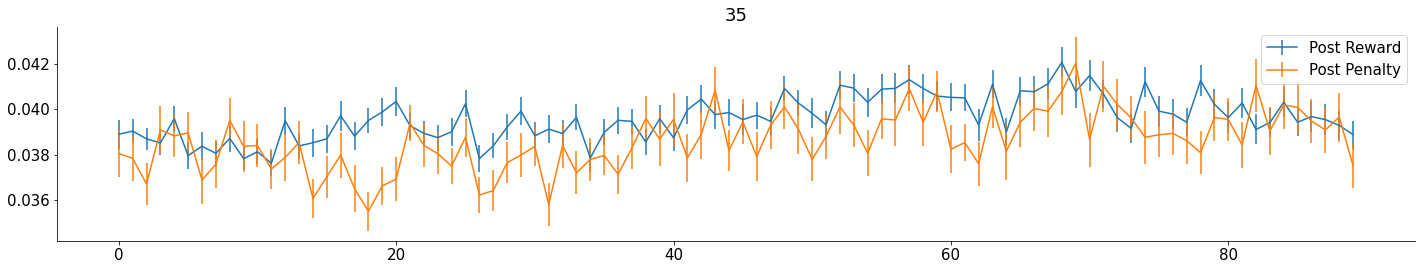

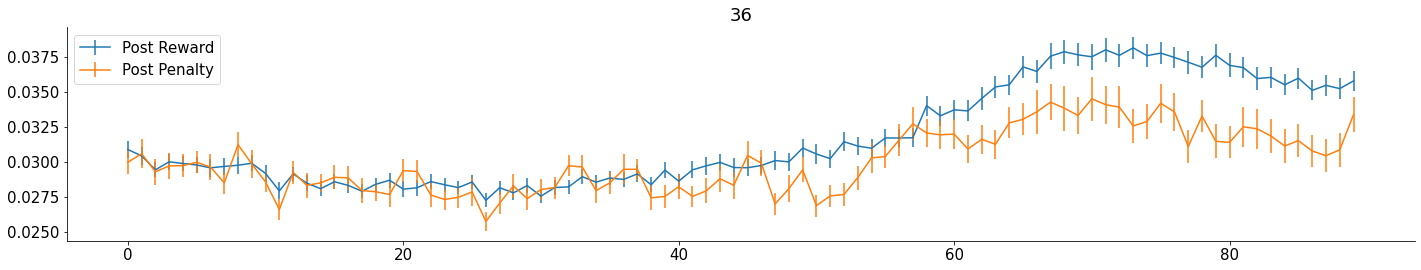

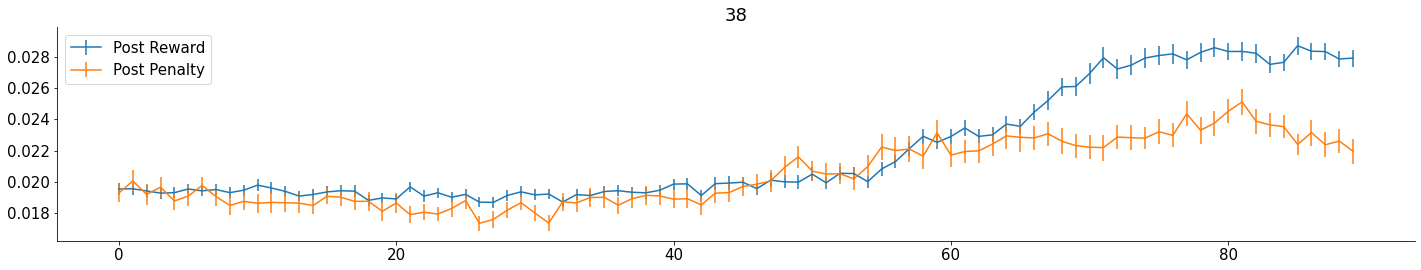

In [13]:
# for name, s, in dict_by_area.items():
#   plot_by_pretrial_feedback(s, dat['feedback_type'], title = name, normalize = False)

# 21 24 26 31 for MOs area, feedback in previous trial
session_MOs = [0,3,4,7,11,12,13,21,24,25,26,29,30,31,34,35,36,38]

for i in session_MOs:
  dat = alldat[i]
  s = dat['spks'][:,:,:90]

  plot_by_pretrial_feedback(s, dat['feedback_type'], title = i, normalize = False)

In [15]:
for i in [7, 13, 21, 30]:
  currdat = alldat[i]
  mouse_name = currdat['mouse_name']
  print('mouse name:',mouse_name,'in session',str(i))

mouse name: Hench in session 7
mouse name: Lederberg in session 13
mouse name: Muller in session 21
mouse name: Richards in session 30


### Session Selection

In [38]:
### session 21
# 13, 21, 30
sessionNum =7
area_name = 'MOs'

dat_curr = alldat[sessionNum]

## delete the 1 st trial in order to use previous trial information
fb_pre = dat_curr['feedback_type'][:-1]
resp_pre = dat_curr['response'][:-1]

resp = dat_curr['response'][1:]
corr = dat_curr['feedback_type'][1:]

brain_area = dat_curr['brain_area']

gocue = dat_curr['gocue'][1:]
first_gocue = np.min(gocue)
last_bin = 50 + round(first_gocue*100) - 1

spks = dat_curr['spks'][:,:,:last_bin] # last time bin before gocue onset
spks = spks[:,1:,:]

# print out the format
print('fb_pre =',fb_pre.shape[0],'\n',
      'resp_pre =',resp_pre.shape[0],'\n',
      'resp =',resp.shape[0],'\n',
      'spks shape (neuron, trial, time) =',spks.shape)


# delete nogo trial (resp=0)
isgo = resp != 0
print('In all', resp.shape[0],'trials (after deleting 1st trial)','\n',
      'After deleting nogo trial,', np.sum(isgo), 'trials left')
# select brain region
isNeededArea = brain_area == area_name
print('In all', brain_area.shape[0],'neurons','\n',
      'After choosing specific area,', np.sum(isNeededArea), 'neurons left')

fb_pre_go = fb_pre[isgo]
resp_pre_go = resp_pre[isgo]
resp_go = resp[isgo]
corr_go = corr[isgo]

resp_fb = resp_pre_go * fb_pre_go # 1: encourage Right choice, -1: encourage left choice

spks = spks[:,isgo,:]
spks = spks[isNeededArea,:,:]

fb_pre = 249 
 resp_pre = 249 
 resp = 249 
 spks shape (neuron, trial, time) = (1156, 249, 98)
In all 249 trials (after deleting 1st trial) 
 After deleting nogo trial, 156 trials left
In all 1156 neurons 
 After choosing specific area, 112 neurons left


## PCA Analysis

In [39]:
# construct matrix X: [time * neuron]
spks_trialAveraged = np.transpose(np.mean(spks,1))
spks_trialAveraged.shape

X = spks_trialAveraged

X_postReward = np.transpose(np.mean(spks[:,fb_pre_go == 1,:],1))
X_postPenalty = np.transpose(np.mean(spks[:,fb_pre_go == -1,:],1))

X_r = np.transpose(np.mean(spks[:,resp_go == -1,:],1))
X_l = np.transpose(np.mean(spks[:,resp_go == 1,:],1))

X_true = np.transpose(np.mean(spks[:,corr_go == 1,:],1))
X_false = np.transpose(np.mean(spks[:,corr_go == -1,:],1))

X_postL = np.transpose(np.mean(spks[:,resp_pre_go == 1,:],1))
X_postR = np.transpose(np.mean(spks[:,resp_pre_go == -1,:],1))

X_reinL = np.transpose(np.mean(spks[:,resp_fb == 1,:],1))
X_reinR = np.transpose(np.mean(spks[:,resp_fb == -1,:],1))



## consider reinforcement history
# idx_reinL_L = ((resp_fb == 1) & (resp_go == 1))
# idx_reinR_L = ((resp_fb == -1) & (resp_go == 1))
# idx_reinL_R = ((resp_fb == 1) & (resp_go == -1))
# idx_reinR_R = ((resp_fb == -1) & (resp_go == -1))

## only consider feedback history
idx_reinL_L = ((fb_pre_go == 1) & (resp_go == 1)) # rew_L
idx_reinR_L = ((fb_pre_go == -1) & (resp_go == 1)) # pen_L
idx_reinL_R = ((fb_pre_go == 1) & (resp_go == -1)) # rew_R
idx_reinR_R = ((fb_pre_go == -1) & (resp_go == -1)) # pen_R

X_reinL_L = np.transpose(np.mean(spks[:,idx_reinL_L,:],1))
X_reinR_L = np.transpose(np.mean(spks[:,idx_reinR_L,:],1))
X_reinL_R = np.transpose(np.mean(spks[:,idx_reinL_R,:],1))
X_reinR_R = np.transpose(np.mean(spks[:,idx_reinR_R,:],1))

In [40]:
print('all mat :',X.shape)

all mat : (98, 112)


## 2D pca analysis

In [41]:
X = spks_trialAveraged

pca_2 = PCA(n_components=2)
pca_2.fit(X)
print(pca_2.explained_variance_ratio_)

# pca_auto = PCA(n_components='mle')
# pca_auto.fit(X)
# print(pca_auto.explained_variance_ratio_)

X_trans = pca_2.fit_transform(X)

[0.73360067 0.08763864]


In [42]:
comp = pca_2.components_
X_M = X - X.mean()
sim = np.dot(X_M,np.linalg.pinv(comp))
# print(sim - X_trans) # [0.21376347 0.05351474], ???

X_postPenalty_trans = np.dot(X_postPenalty - X_postPenalty.mean(),np.linalg.pinv(comp))
X_postReward_trans = np.dot(X_postReward - X_postReward.mean(),np.linalg.pinv(comp))

X_r_trans = np.dot(X_r - X_r.mean(),np.linalg.pinv(comp))
X_l_trans = np.dot(X_l - X_l.mean(),np.linalg.pinv(comp))

X_true_trans = np.dot(X_true - X_true.mean(),np.linalg.pinv(comp))
X_false_trans = np.dot(X_false - X_false.mean(),np.linalg.pinv(comp))

X_postL_trans = np.dot(X_postL - X_postL.mean(),np.linalg.pinv(comp))
X_postR_trans = np.dot(X_postR - X_postR.mean(),np.linalg.pinv(comp))

X_reinL_trans = np.dot(X_reinL - X_reinL.mean(),np.linalg.pinv(comp))
X_reinR_trans = np.dot(X_reinR - X_reinR.mean(),np.linalg.pinv(comp))

X_reinL_L_trans = np.dot(X_reinL_L - X_reinL_L.mean(),np.linalg.pinv(comp))
X_reinR_L_trans = np.dot(X_reinR_L - X_reinR_L.mean(),np.linalg.pinv(comp))
X_reinL_R_trans = np.dot(X_reinL_R - X_reinL_R.mean(),np.linalg.pinv(comp))
X_reinR_R_trans = np.dot(X_reinR_R - X_reinR_R.mean(),np.linalg.pinv(comp))

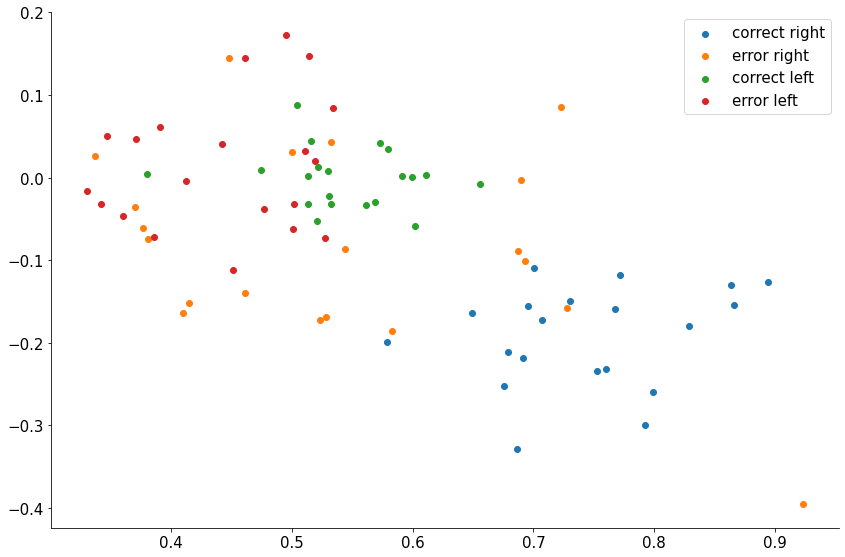

In [43]:
# divide trials into 4 parts: correct left, error left, correct right, error right
# only use last 20 time bins
idx_corr_r = (corr_go == 1) & (resp_go == -1)
idx_err_r = (corr_go == -1) & (resp_go == -1)
idx_corr_l = (corr_go == 1) & (resp_go == 1)
idx_err_l = (corr_go == -1) & (resp_go == 1)


X_corr_r = np.transpose(np.mean(spks[:,idx_corr_r,:],1))
X_err_r = np.transpose(np.mean(spks[:,idx_err_r,:],1))
X_corr_l = np.transpose(np.mean(spks[:,idx_corr_l,:],1))
X_err_l = np.transpose(np.mean(spks[:,idx_err_l,:],1))

X_corr_r_trans = np.dot(X_corr_r - X_corr_r.mean(),np.linalg.pinv(comp))
X_err_r_trans = np.dot(X_err_r - X_err_r.mean(),np.linalg.pinv(comp))
X_corr_l_trans = np.dot(X_corr_l - X_corr_l.mean(),np.linalg.pinv(comp))
X_err_l_trans = np.dot(X_err_l - X_err_l.mean(),np.linalg.pinv(comp))

X1 = X_corr_r_trans[-20:,:]
X2 = X_err_r_trans[-20:,:]
X3 = X_corr_l_trans[-20:,:]
X4 = X_err_l_trans[-20:,:]

# plot
plt.figure(figsize = (12,8))
plt.scatter(X1[:,0],X1[:,1],label = 'correct right')
plt.scatter(X2[:,0],X2[:,1],label = 'error right')
plt.scatter(X3[:,0],X3[:,1],label = 'correct left')
plt.scatter(X4[:,0],X4[:,1],label = 'error left')
plt.legend()

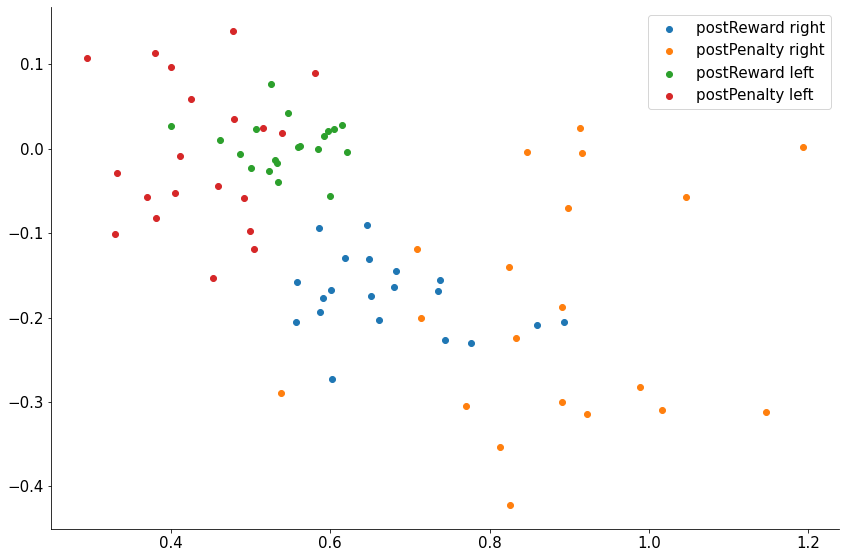

In [44]:
# divide trials into 4 parts: postrew left, postpen left, post rew right, postpen right
# only use last 20 time bins
idx_corr_r = (fb_pre_go == 1) & (resp_go == -1)
idx_err_r = (fb_pre_go == -1) & (resp_go == -1)
idx_corr_l = (fb_pre_go == 1) & (resp_go == 1)
idx_err_l = (fb_pre_go == -1) & (resp_go == 1)


X_corr_r = np.transpose(np.mean(spks[:,idx_corr_r,:],1))
X_err_r = np.transpose(np.mean(spks[:,idx_err_r,:],1))
X_corr_l = np.transpose(np.mean(spks[:,idx_corr_l,:],1))
X_err_l = np.transpose(np.mean(spks[:,idx_err_l,:],1))

X_corr_r_trans = np.dot(X_corr_r - X_corr_r.mean(),np.linalg.pinv(comp))
X_err_r_trans = np.dot(X_err_r - X_err_r.mean(),np.linalg.pinv(comp))
X_corr_l_trans = np.dot(X_corr_l - X_corr_l.mean(),np.linalg.pinv(comp))
X_err_l_trans = np.dot(X_err_l - X_err_l.mean(),np.linalg.pinv(comp))

X1 = X_corr_r_trans[-20:,:]
X2 = X_err_r_trans[-20:,:]
X3 = X_corr_l_trans[-20:,:]
X4 = X_err_l_trans[-20:,:]

# plot
plt.figure(figsize = (12,8))
plt.scatter(X1[:,0],X1[:,1],label = 'postReward right')
plt.scatter(X2[:,0],X2[:,1],label = 'postPenalty right')
plt.scatter(X3[:,0],X3[:,1],label = 'postReward left')
plt.scatter(X4[:,0],X4[:,1],label = 'postPenalty left')
plt.legend()

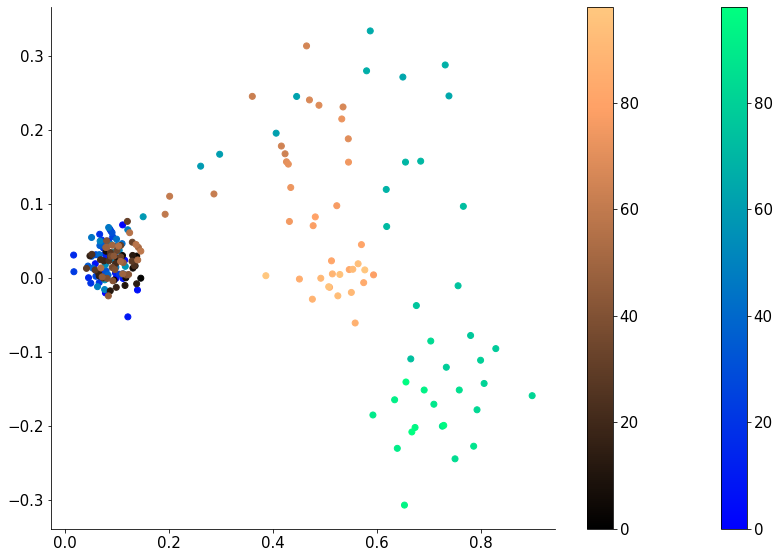

In [45]:
# plot according to the response in current trial
X1 = X_r_trans
X2 = X_l_trans

label1 = 'right final'
label2 = 'left final'

plot_2d_project(X1, X2, label1=label1, label2=label2)

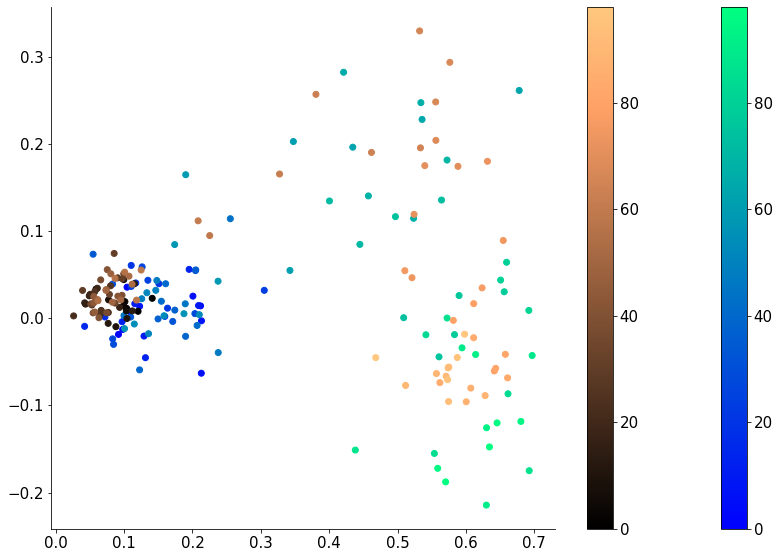

In [46]:
# plot according to the feed back in previous trial
X1 = X_postPenalty_trans
X2 = X_postReward_trans

label1 = 'post Penalty'
label2 = 'post Reward'

plot_2d_project(X1, X2, label1=label1, label2=label2)

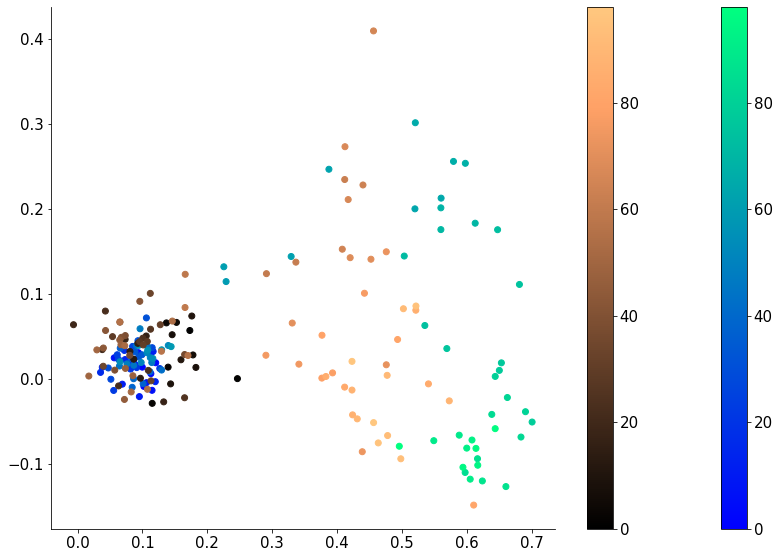

In [47]:
# plot according to the correctness in the current trial
X1 = X_true_trans
X2 = X_false_trans

label1 = 'correct final'
label2 = 'error final'

plot_2d_project(X1, X2, label1=label1, label2=label2)

## 3D pca analysis

In [48]:
X = spks_trialAveraged

pca_3 = PCA(n_components=3)
pca_3.fit(X)
print(pca_3.explained_variance_ratio_)

# pca_auto = PCA(n_components='mle')
# pca_auto.fit(X)
# print(pca_auto.explained_variance_ratio_)

X_trans = pca_3.fit_transform(X)

[0.73360067 0.08763864 0.02004842]


In [49]:
comp = pca_3.components_
X_M = X - X.mean()
sim = np.dot(X_M,np.linalg.pinv(comp))
# sim - X_trans: repmat([0.21376347, 0.05351474, 0.01102241] ,97,1)                 ????

X_postPenalty_trans = np.dot(X_postPenalty - X_postPenalty.mean(),np.linalg.pinv(comp))
X_postReward_trans = np.dot(X_postReward - X_postReward.mean(),np.linalg.pinv(comp))

X_r_trans = np.dot(X_r - X_r.mean(),np.linalg.pinv(comp))
X_l_trans = np.dot(X_l - X_l.mean(),np.linalg.pinv(comp))

X_true_trans = np.dot(X_true - X_true.mean(),np.linalg.pinv(comp))
X_false_trans = np.dot(X_false - X_false.mean(),np.linalg.pinv(comp))

X_postL_trans = np.dot(X_postL - X_postL.mean(),np.linalg.pinv(comp))
X_postR_trans = np.dot(X_postR - X_postR.mean(),np.linalg.pinv(comp))

X_reinL_trans = np.dot(X_reinL - X_reinL.mean(),np.linalg.pinv(comp))
X_reinR_trans = np.dot(X_reinR - X_reinR.mean(),np.linalg.pinv(comp))

X_reinL_L_trans = np.dot(X_reinL_L - X_reinL_L.mean(),np.linalg.pinv(comp))
X_reinR_L_trans = np.dot(X_reinR_L - X_reinR_L.mean(),np.linalg.pinv(comp))
X_reinL_R_trans = np.dot(X_reinL_R - X_reinL_R.mean(),np.linalg.pinv(comp))
X_reinR_R_trans = np.dot(X_reinR_R - X_reinR_R.mean(),np.linalg.pinv(comp))

### Divided by Left/Right in current trial

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


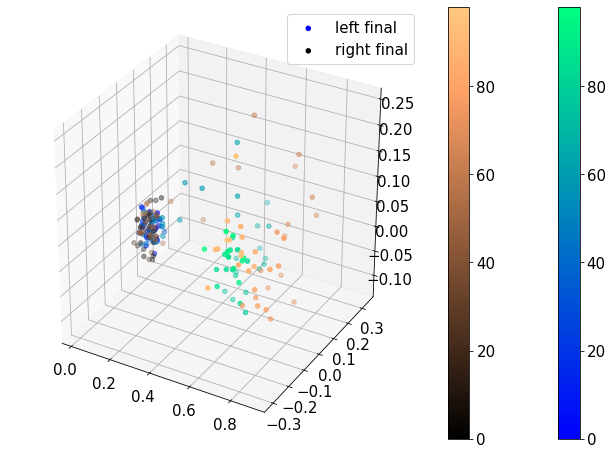

In [50]:
plot_3d(X_l_trans,X_r_trans,cmap1='winter',cmap2='copper',label1='left final',label2='right final')

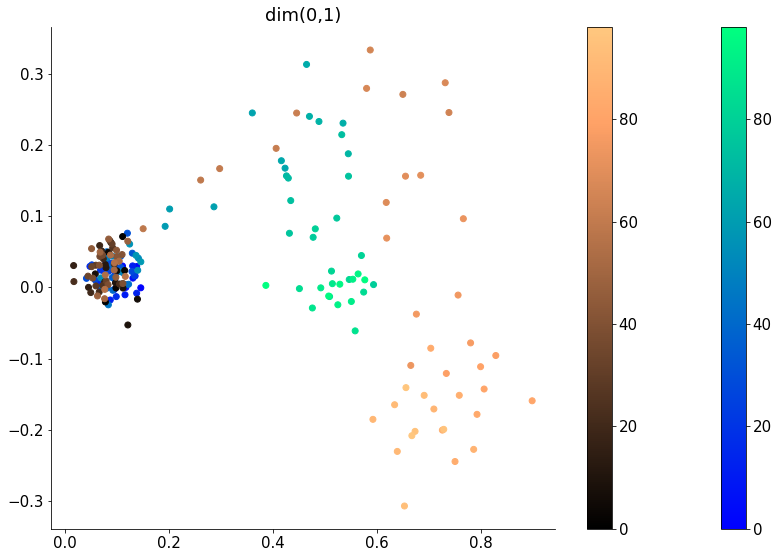

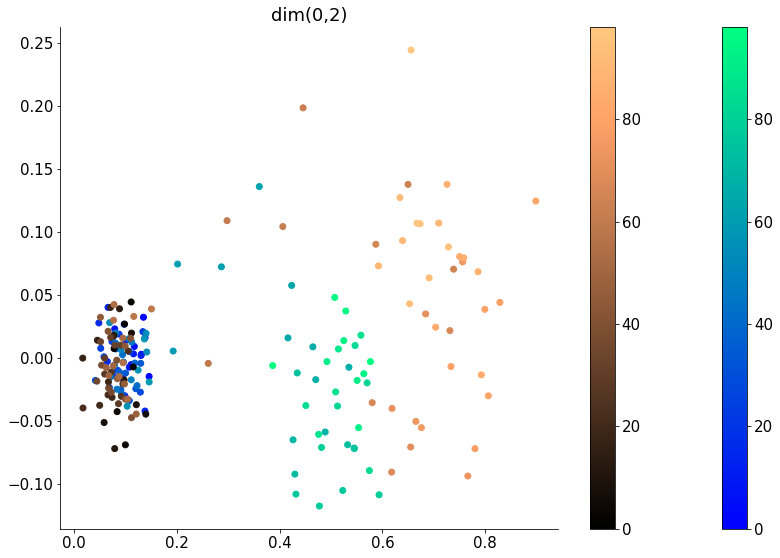

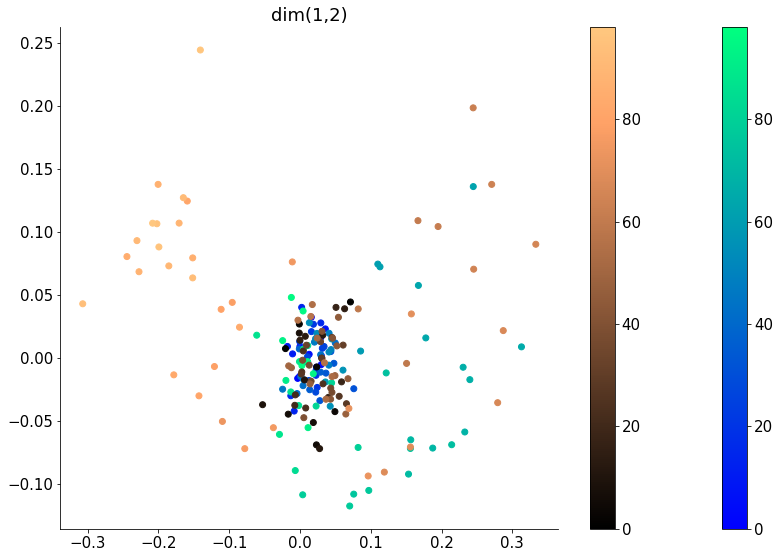

In [51]:
plot_2d_project(X_l_trans,X_r_trans,dim = (0,1),cmap1='winter',cmap2='copper',label1='left final',label2='right final', title = 'dim(0,1)')
plot_2d_project(X_l_trans,X_r_trans,dim = (0,2),cmap1='winter',cmap2='copper',label1='left final',label2='right final', title = 'dim(0,2)')
plot_2d_project(X_l_trans,X_r_trans,dim = (1,2),cmap1='winter',cmap2='copper',label1='left final',label2='right final', title = 'dim(1,2)')

### Divided by feedback in previous trial

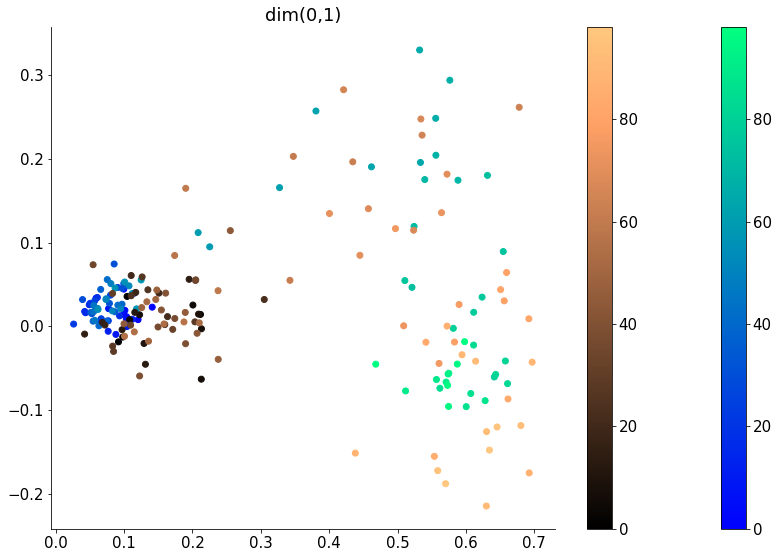

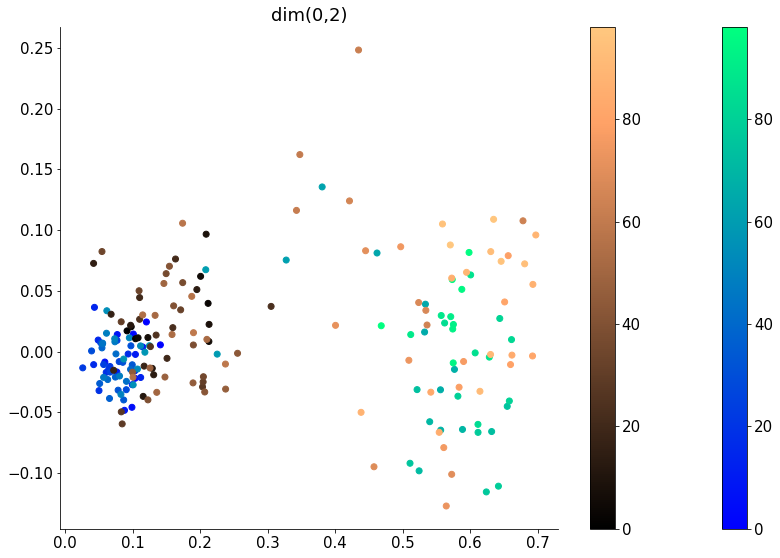

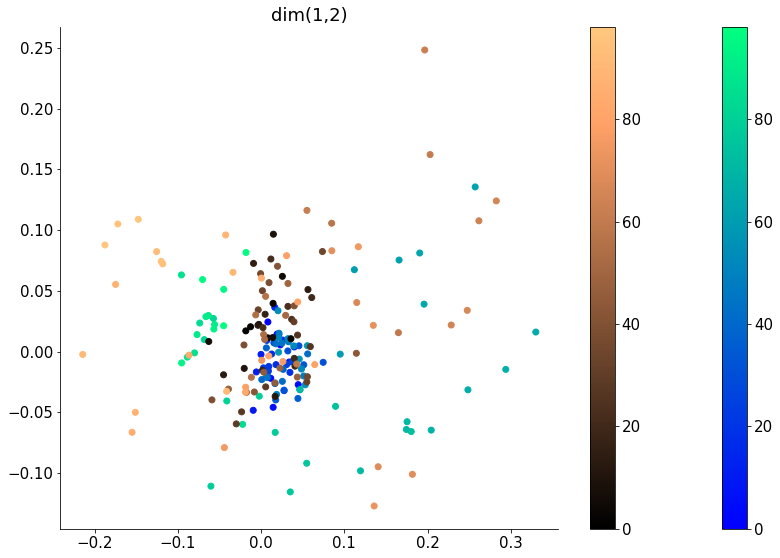

In [52]:
## trial splited by previous feedback
# this is better
plot_2d_project(X_postReward_trans,X_postPenalty_trans,dim=(0,1),
                cmap1='winter',cmap2='copper',label1='post reward',label2='post penalty', title = 'dim(0,1)')

plot_2d_project(X_postReward_trans,X_postPenalty_trans,dim=(0,2),
                cmap1='winter',cmap2='copper',label1='post reward',label2='post penalty', title = 'dim(0,2)')

# this is not good
plot_2d_project(X_postReward_trans,X_postPenalty_trans,dim=(1,2),
                cmap1='winter',cmap2='copper',label1='post reward',label2='post penalty', title = 'dim(1,2)')

### Divided by correctness in current trial

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


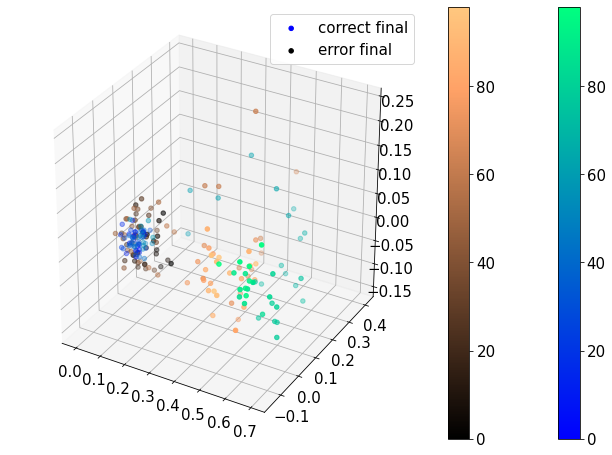

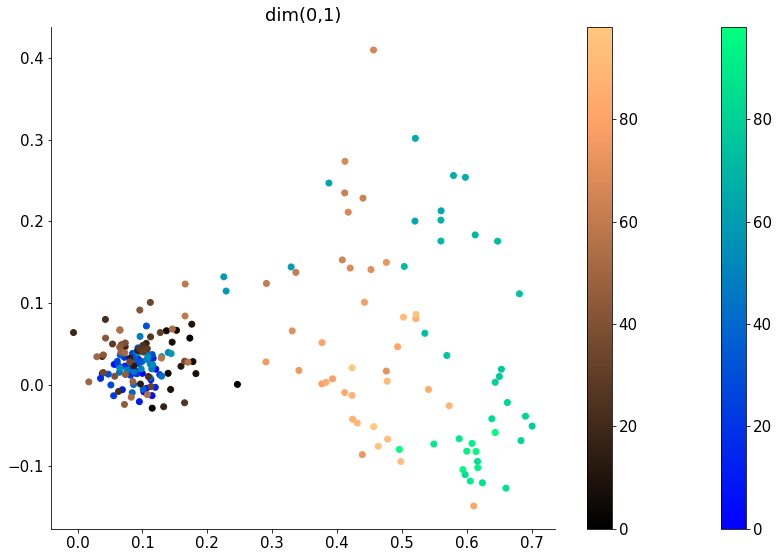

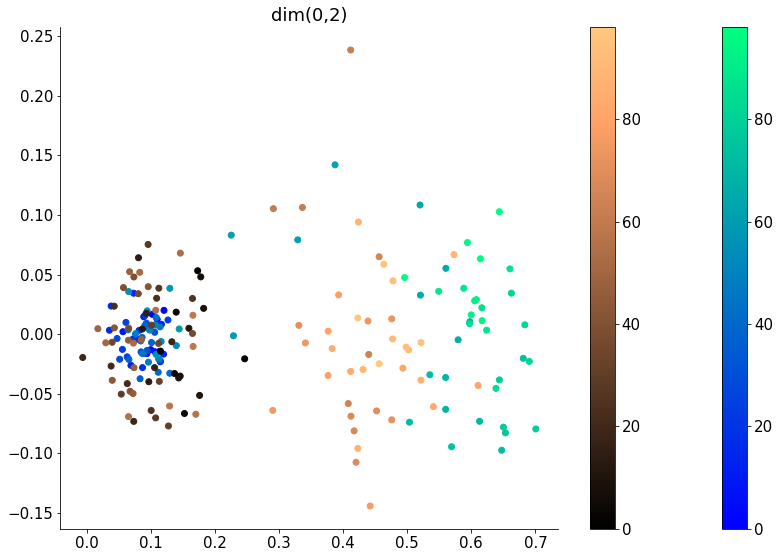

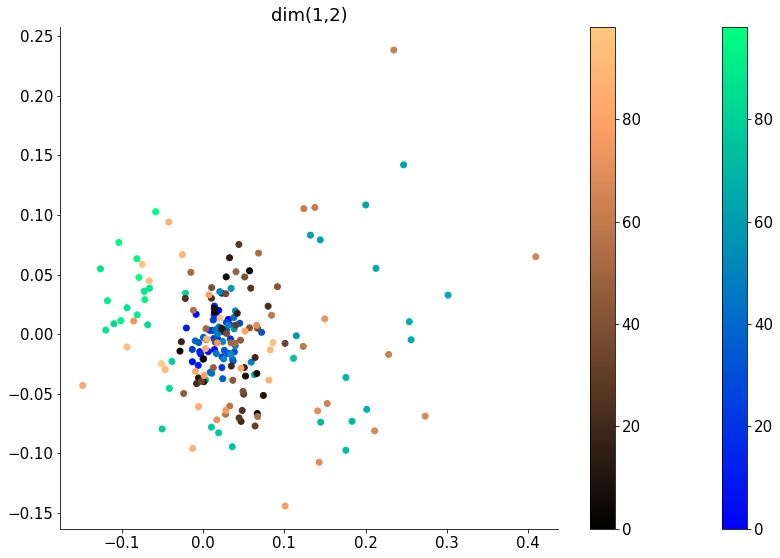

In [53]:
X1 = X_true_trans
X2 = X_false_trans
label1 = 'correct final'
label2 = 'error final'

plot_3d(X1,X2,cmap1='winter',cmap2='copper',label1=label1,label2=label2)


plot_2d_project(X1,X2,dim=(0,1),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,1)')
plot_2d_project(X1,X2,dim=(0,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,2)')
plot_2d_project(X1,X2,dim=(1,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(1,2)')

# plot_2d_project_line(X1,X2,dim=(0,1),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,1)')
# plot_2d_project_line(X1,X2,dim=(0,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,2)')
# plot_2d_project_line(X1,X2,dim=(1,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(1,2)')

### see response in this trial & reinforcement in last trial

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


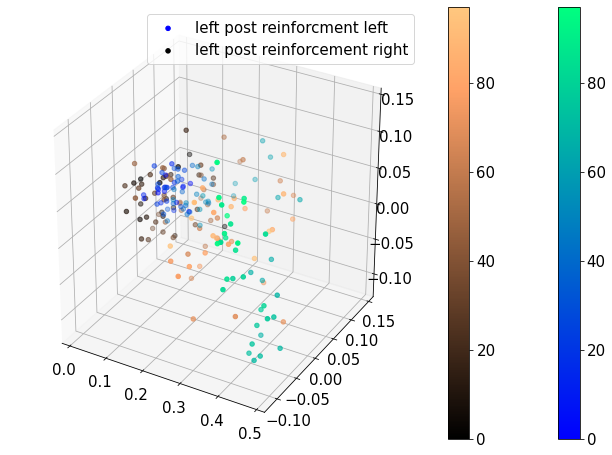

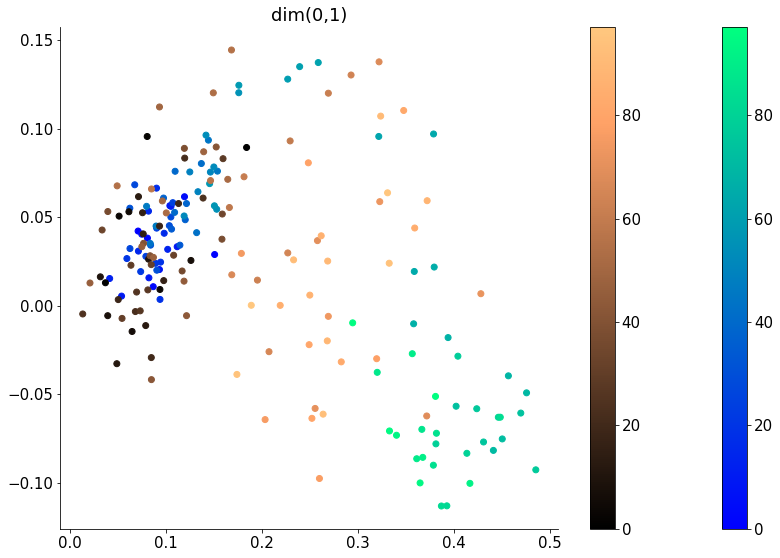

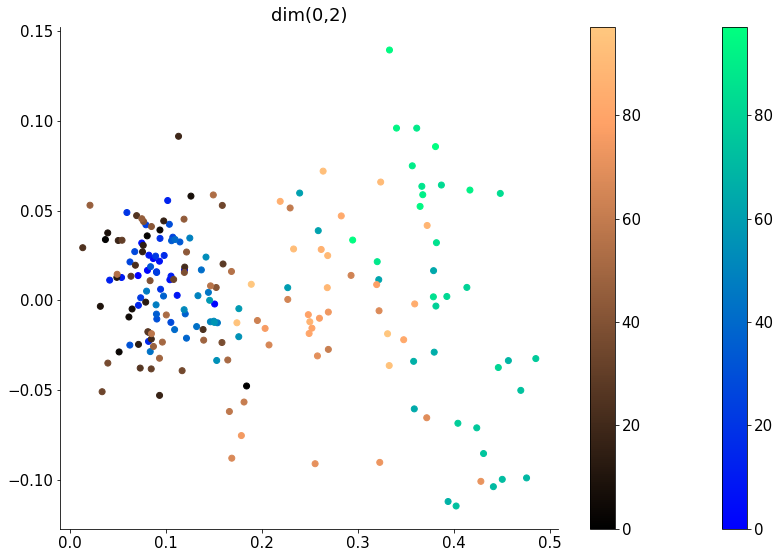

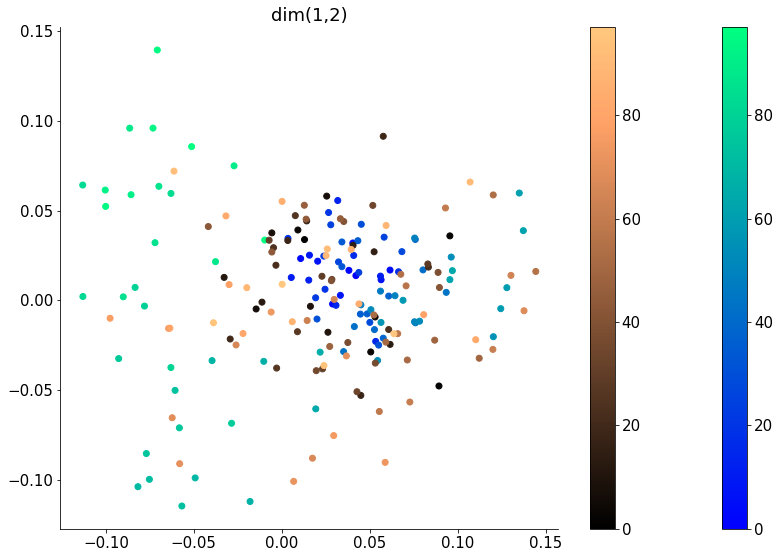

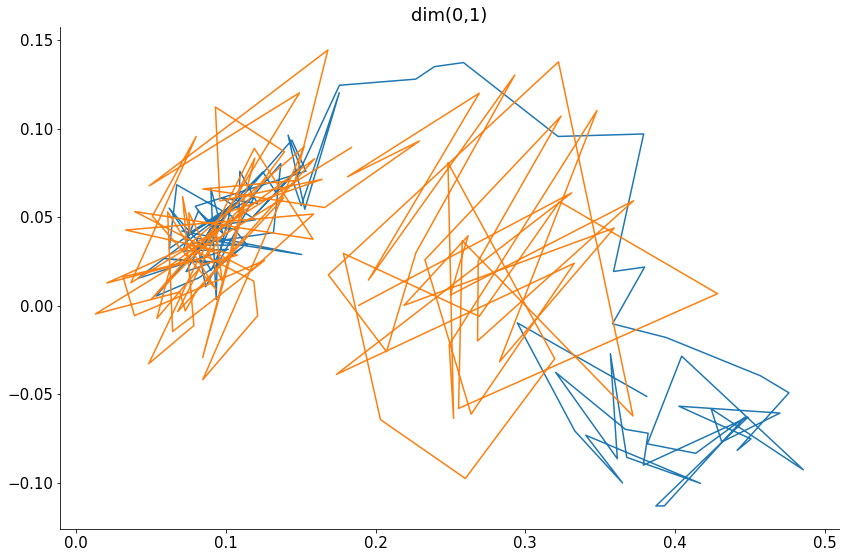

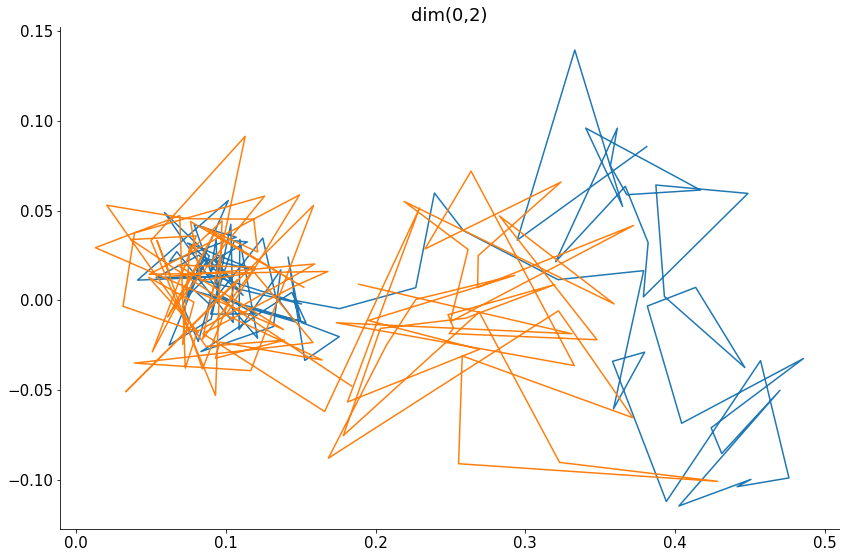

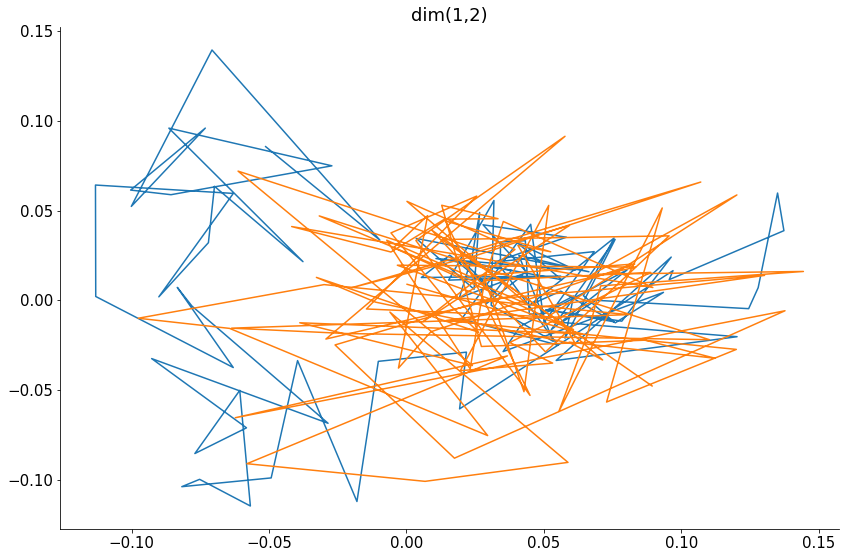

In [ ]:
X1 = X_reinL_L_trans
X2 = X_reinR_L_trans
label1 = 'left post reinforcment left'
label2 = 'left post reinforcement right'

plot_3d(X1,X2,cmap1='winter',cmap2='copper',label1=label1,label2=label2)


plot_2d_project(X1,X2,dim=(0,1),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,1)')
plot_2d_project(X1,X2,dim=(0,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,2)')
plot_2d_project(X1,X2,dim=(1,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(1,2)')


# plot_2d_project_line(X1,X2,dim=(0,1),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,1)')
# plot_2d_project_line(X1,X2,dim=(0,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,2)')
# plot_2d_project_line(X1,X2,dim=(1,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(1,2)')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


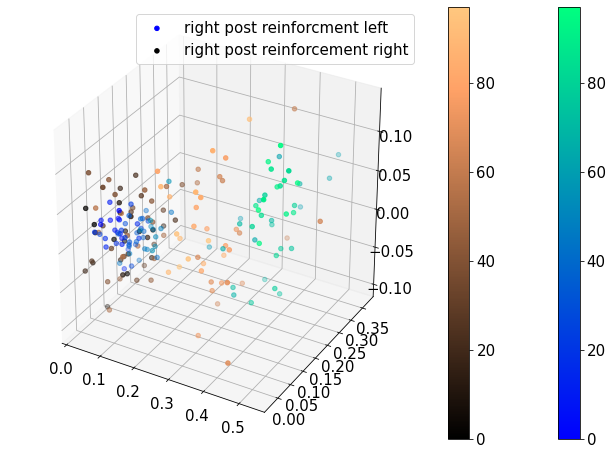

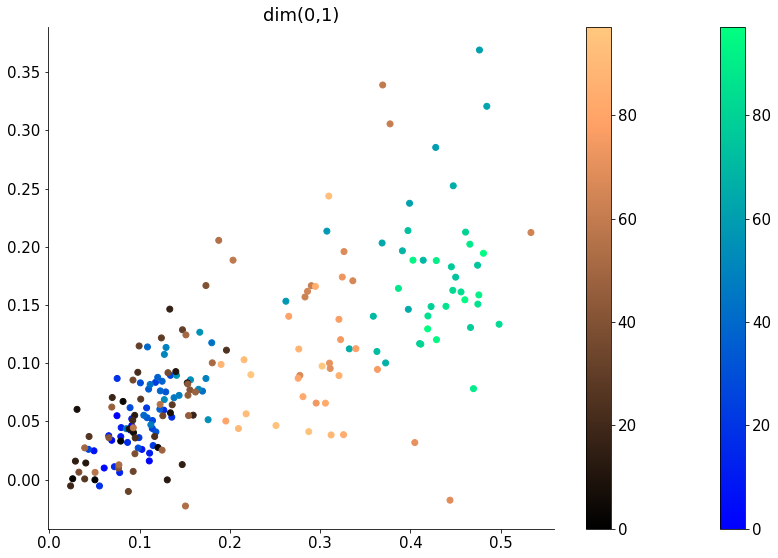

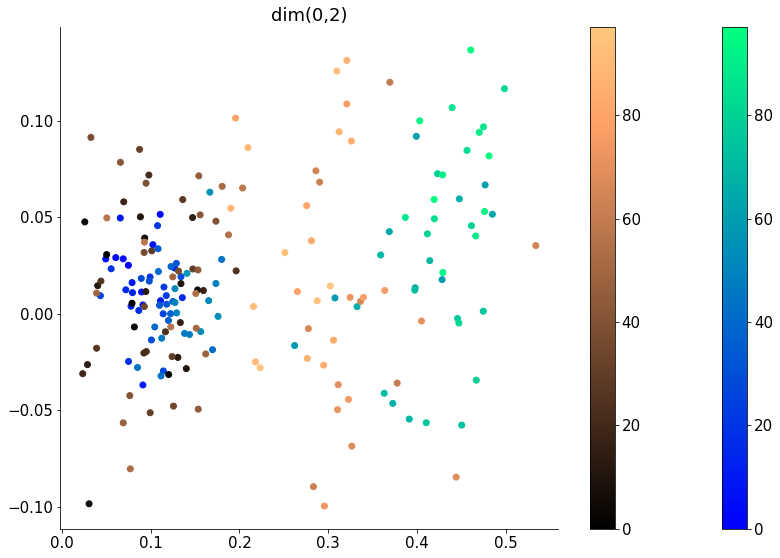

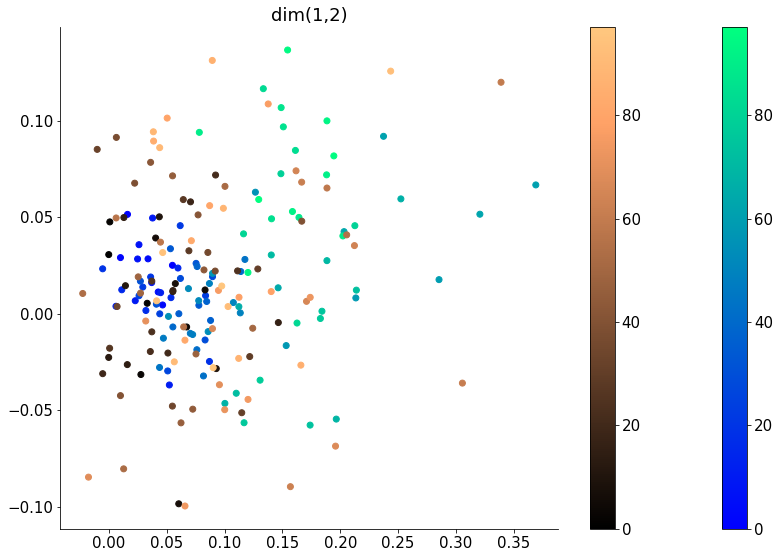

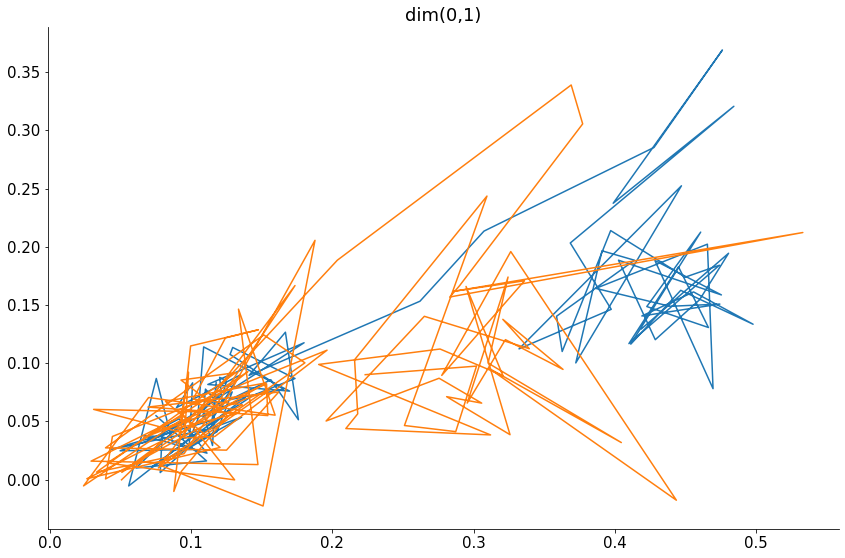

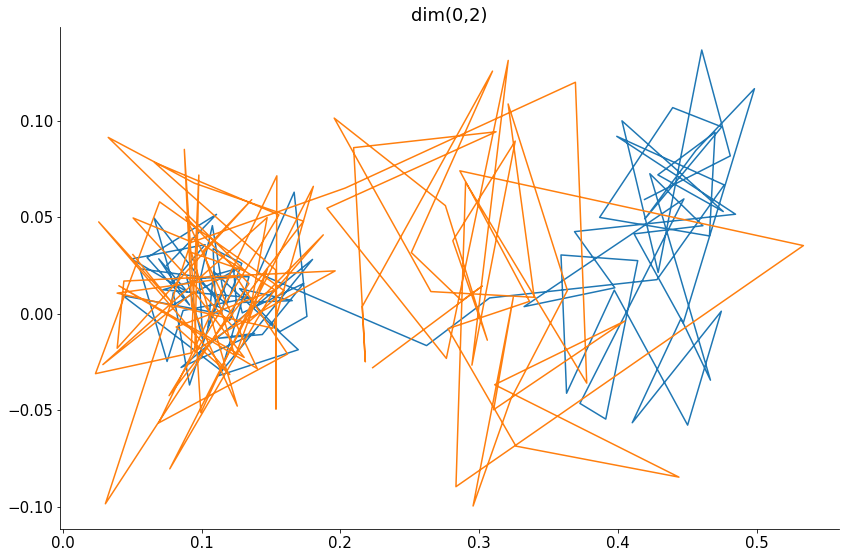

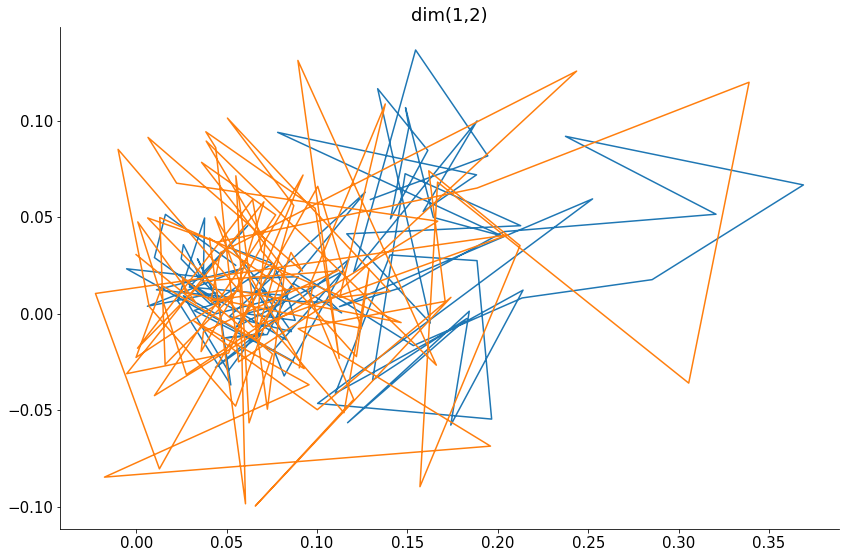

In [ ]:
X1 = X_reinL_R_trans
X2 = X_reinR_R_trans
label1 = 'right post reinforcment left'
label2 = 'right post reinforcement right'

plot_3d(X1,X2,cmap1='winter',cmap2='copper',label1=label1,label2=label2)


plot_2d_project(X1,X2,dim=(0,1),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,1)')
plot_2d_project(X1,X2,dim=(0,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,2)')
plot_2d_project(X1,X2,dim=(1,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(1,2)')

# plot_2d_project_line(X1,X2,dim=(0,1),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,1)')
# plot_2d_project_line(X1,X2,dim=(0,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(0,2)')
# plot_2d_project_line(X1,X2,dim=(1,2),cmap1='winter',cmap2='copper',label1=label1,label2=label2,title='dim(1,2)')

### Not good part

### Divided by Left/Right in previous trial

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


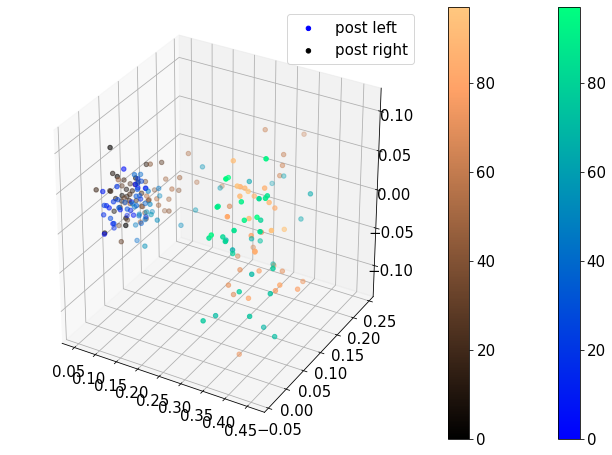

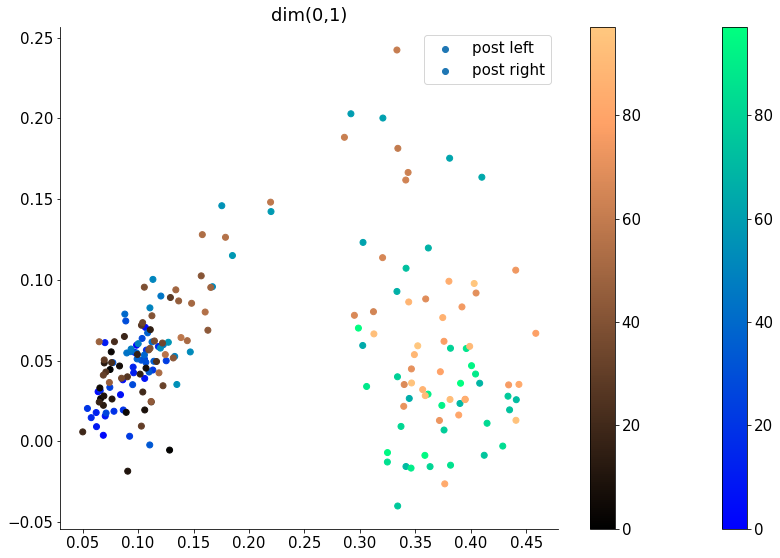

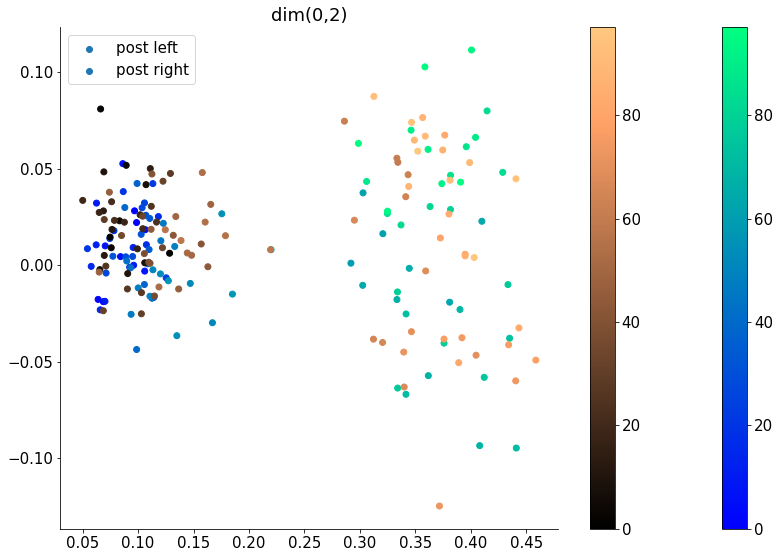

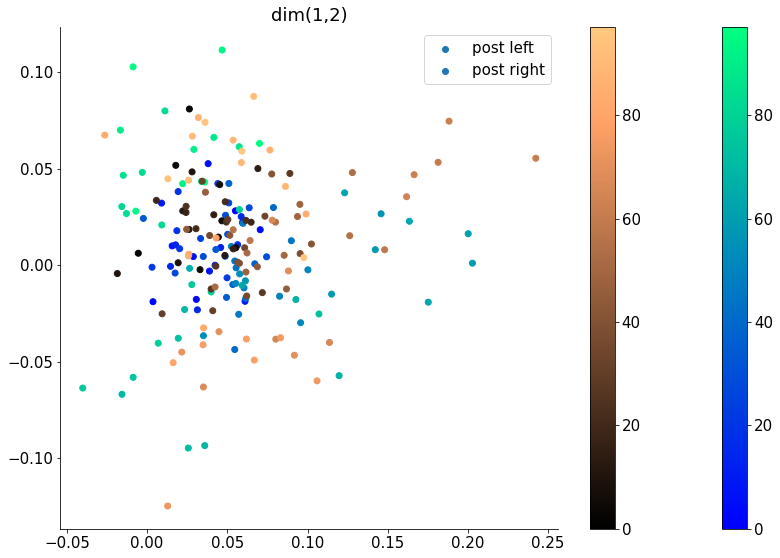

In [ ]:
## trials splited by previous response
# not effective

plot_3d(X_postL_trans,X_postR_trans,cmap1='winter',cmap2='copper',label1='post left',label2='post right')


plot_2d_project(X_postL_trans,X_postR_trans,dim=(0,1),cmap1='winter',cmap2='copper',label1='post left',label2='post right',title='dim(0,1)')
plot_2d_project(X_postL_trans,X_postR_trans,dim=(0,2),cmap1='winter',cmap2='copper',label1='post left',label2='post right',title='dim(0,2)')
plot_2d_project(X_postL_trans,X_postR_trans,dim=(1,2),cmap1='winter',cmap2='copper',label1='post left',label2='post right',title='dim(1,2)')

### Divided by reinforcement direction in previous trial

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


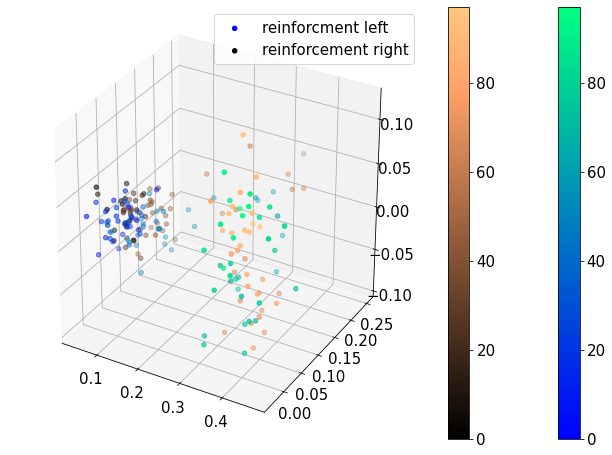

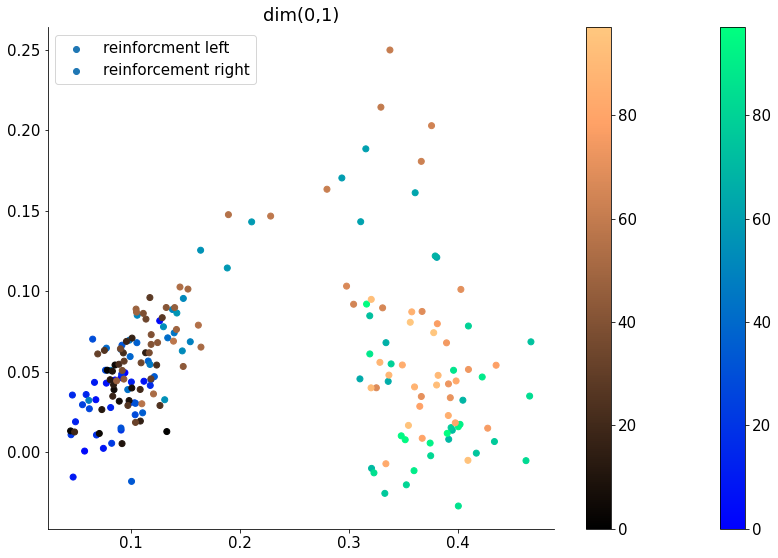

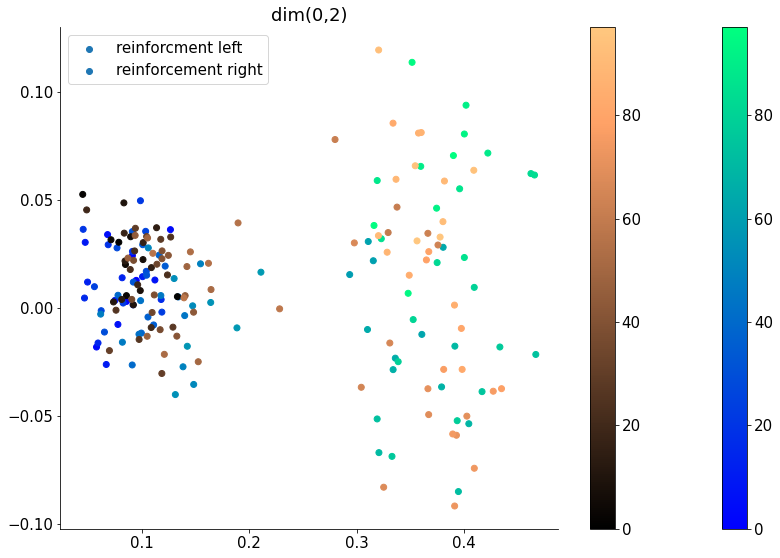

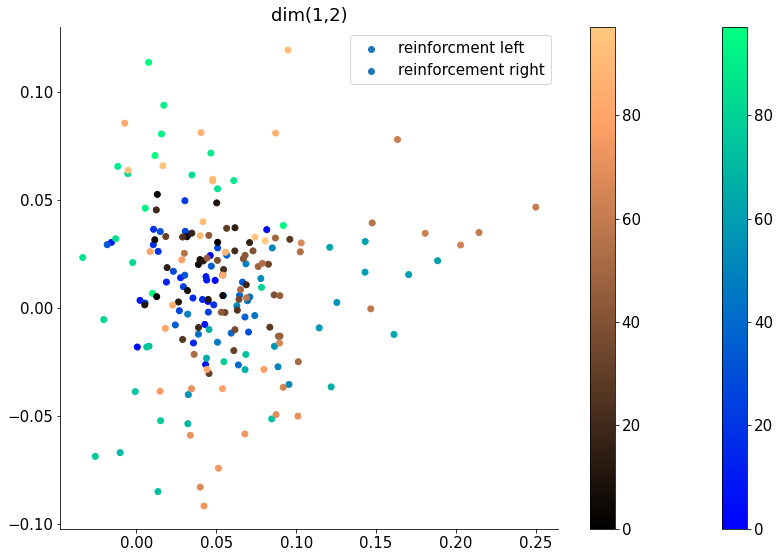

In [ ]:
## trials splited by previous reinforcement
# not effective

plot_3d(X_reinL_trans,X_reinR_trans,cmap1='winter',cmap2='copper',label1='reinforcment left',label2='reinforcement right')


plot_2d_project(X_reinL_trans,X_reinR_trans,dim=(0,1),cmap1='winter',cmap2='copper',label1='reinforcment left',label2='reinforcement right',title='dim(0,1)')
plot_2d_project(X_reinL_trans,X_reinR_trans,dim=(0,2),cmap1='winter',cmap2='copper',label1='reinforcment left',label2='reinforcement right',title='dim(0,2)')
plot_2d_project(X_reinL_trans,X_reinR_trans,dim=(1,2),cmap1='winter',cmap2='copper',label1='reinforcment left',label2='reinforcement right',title='dim(1,2)')

## Glm - (trials, time)

In [ ]:
### General Setup
sessionNum = 13
area_name = 'MOs'

dat_curr = alldat[sessionNum]

## delete the 1 st trial in order to use previous trial information
fb_pre = dat_curr['feedback_type'][:-1]
resp_pre = dat_curr['response'][:-1]

resp = dat_curr['response'][1:]
corr = dat_curr['feedback_type'][1:]

brain_area = dat_curr['brain_area']

gocue = dat_curr['gocue'][1:]
first_gocue = np.min(gocue)
last_bin = 50 + round(first_gocue*100) - 1

spks = dat_curr['spks'][:,:,50:last_bin] # last time bin before gocue onset
spks = spks[:,1:,:]

# print out the format
print('fb_pre =',fb_pre.shape[0],'\n',
      'resp_pre =',resp_pre.shape[0],'\n',
      'resp =',resp.shape[0],'\n',
      'spks shape (neuron, trial, time) =',spks.shape)


# delete nogo trial (resp=0)
isgo = resp != 0
print('In all', resp.shape[0],'trials (after deleting 1st trial)','\n',
      'After deleting nogo trial,', np.sum(isgo), 'trials left')
# select brain region
isNeededArea = brain_area == area_name
print('In all', brain_area.shape[0],'neurons','\n',
      'After choosing specific area,', np.sum(isNeededArea), 'neurons left')

fb_pre_go = fb_pre[isgo]
resp_pre_go = resp_pre[isgo]
resp_go = resp[isgo]
corr_go = corr[isgo]

resp_fb = resp_pre_go * fb_pre_go # 1: encourage Right choice, -1: encourage left choice

spks = spks[:,isgo,:]
spks = spks[isNeededArea,:,:]

fb_pre = 267 
 resp_pre = 267 
 resp = 267 
 spks shape (neuron, trial, time) = (756, 267, 39)
In all 267 trials (after deleting 1st trial) 
 After deleting nogo trial, 206 trials left
In all 756 neurons 
 After choosing specific area, 186 neurons left


In [ ]:
print('spks.shape =', spks.shape, '\n',
'fb_pre_go.shape =', fb_pre_go.shape, '\n',
'corr_go.shape =', corr_go.shape, '\n',
'resp_go.shape =', resp_go.shape)

spks.shape = (186, 206, 39) 
 fb_pre_go.shape = (206,) 
 corr_go.shape = (206,) 
 resp_go.shape = (206,)


### dim_left = neuron

In [ ]:
## due to frequency issue, use boot strap.
def boot_strap(X, reference, each = 100): # generate new set of data
    
    idx_postRew = reference == 1
    idx_postPen = reference == -1

    X_postRew = X[idx_postRew,:]
    row_postRew = X_postRew.shape[0]
    row_postRew_choice = np.random.choice(row_postRew, each, replace=True)
    X_postRew_sample = X_postRew[row_postRew_choice,:]

    X_postPen = X[idx_postPen,:]
    row_postPen = X_postPen.shape[0]
    row_postPen_choice = np.random.choice(row_postPen, each, replace=True)
    X_postPen_sample = X_postPen[row_postPen_choice,:]

    X_new = np.concatenate((X_postRew_sample, X_postPen_sample), axis = 0)
    y_new = np.concatenate((np.ones(each), -1*np.ones(each)),axis=0)

    return X_new, y_new


In [ ]:
# permutation test with boot strap
# predict feedbck in previous trial

times = 20 # boot strap time
acc_ori_all = np.zeros(times)
cvd_ori_all = np.zeros(times)
acc_scrb_all = np.zeros(times)
cvd_scrb_all = np.zeros(times)

for i in range(times):
    print('\n','running the', str(i), 'th boot strap ...','\n')
    ori_acc, ori_cvd, scrambled_acc_collect, scrambled_cvd_collect = neuronModel3D_perm(spks, fb_pre_go, dim_left = 'neuron', 
                                                                                        penalty='l1',C=10, cv=10, repeat = 16, bootStrap=True)

    print('\n')

    print('ori_acc =', ori_acc, '\n', 
          'mean scrambled_acc =', np.mean(scrambled_acc_collect), '\n', 
          'ori_cvd =', ori_cvd, '\n',
          'mean scrambled_cvd =', np.mean(np.mean(scrambled_cvd_collect)))

    scrambled_cvd_perRepeat = np.mean(scrambled_cvd_collect,1)
    
    acc_ori_all[i] = ori_acc
    acc_scrb_all[i] = np.mean(scrambled_acc_collect)
    cvd_ori_all[i] = ori_cvd
    cvd_scrb_all[i] = np.mean(scrambled_cvd_perRepeat)


 running the 0 th boot strap ... 

s shape = (186, 206, 39)
X dim (neuron left): (206, 186)
add "1"s -> (206, 187)

 after boot_strap, X -> (200, 187)
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 10
running epoch 11
running epoch 12
running epoch 13
running epoch 14
running epoch 15
finished


ori_acc = 0.98 
 mean scrambled_acc = 0.748125 
 ori_cvd = 0.845 
 mean scrambled_cvd = 0.49281250000000004

 running the 1 th boot strap ... 

s shape = (186, 206, 39)
X dim (neuron left): (206, 186)
add "1"s -> (206, 187)

 after boot_strap, X -> (200, 187)
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 10
running epoch 11
running epoch 12
running epoch 13
running epoch 14
running epoch 15
finished


ori_acc = 0.955 
 mean scrambled_acc = 0.7

In [ ]:
print('acc_ori_all=', np.mean(acc_ori_all), '\n', 
      'acc_scrb_all =', np.mean(acc_scrb_all), '\n', 
      'cvd_ori_all =', np.mean(cvd_ori_all), '\n',
      'cvd_scrb_all', np.mean(np.mean(cvd_scrb_all)))

# t test 
stats.ttest_rel(cvd_ori_all, cvd_scrb_all, alternative = 'greater') # pvalue=2.190745801849997e-28

acc_ori_all= 0.7455 
 acc_scrb_all = 0.6290625000000001 
 cvd_ori_all = 0.6495 
 cvd_scrb_all 0.49826562500000005


Ttest_relResult(statistic=11.428879996103914, pvalue=2.938499873654456e-10)

In [ ]:
# permutation test with boot strap
# predict correctness in current trial

times = 20 # boot strap time
acc_ori_all = np.zeros(times)
cvd_ori_all = np.zeros(times)
acc_scrb_all = np.zeros(times)
cvd_scrb_all = np.zeros(times)

for i in range(times):
    print('\n','running the', str(i), 'th boot strap ...','\n')
    ori_acc, ori_cvd, scrambled_acc_collect, scrambled_cvd_collect = neuronModel3D_perm(spks, corr_go, dim_left = 'neuron', 
                                                                                        penalty='none', cv=10, repeat = 16, bootStrap=True)

    print('\n')

    print('ori_acc =', ori_acc, '\n', 
          'mean scrambled_acc =', np.mean(scrambled_acc_collect), '\n', 
          'ori_cvd =', ori_cvd, '\n',
          'mean scrambled_cvd =', np.mean(np.mean(scrambled_cvd_collect)))

    scrambled_cvd_perRepeat = np.mean(scrambled_cvd_collect,1)
    
    acc_ori_all[i] = ori_acc
    acc_scrb_all[i] = np.mean(scrambled_acc_collect)
    cvd_ori_all[i] = ori_cvd
    cvd_scrb_all[i] = np.mean(scrambled_cvd_perRepeat)


 running the 0 th boot strap ... 

s shape = (186, 206, 39)
X dim (neuron left): (206, 186)
add "1"s -> (206, 187)

 after boot_strap, X -> (200, 187)
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 10
running epoch 11
running epoch 12
running epoch 13
running epoch 14
running epoch 15
finished


ori_acc = 1.0 
 mean scrambled_acc = 0.8209375000000001 
 ori_cvd = 0.8949999999999999 
 mean scrambled_cvd = 0.5075000000000001

 running the 1 th boot strap ... 

s shape = (186, 206, 39)
X dim (neuron left): (206, 186)
add "1"s -> (206, 187)

 after boot_strap, X -> (200, 187)
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 10
running epoch 11
running epoch 12
running epoch 13
running epoch 14
running epoch 15
finished


ori_acc = 1.0 
 mean 

In [ ]:
print('acc_ori_all=', np.mean(acc_ori_all), '\n', 
      'acc_scrb_all =', np.mean(acc_scrb_all), '\n', 
      'cvd_ori_all =', np.mean(cvd_ori_all), '\n',
      'cvd_scrb_all', np.mean(np.mean(cvd_scrb_all)))

# t test 
stats.ttest_rel(cvd_ori_all, cvd_scrb_all, alternative = 'greater') # pvalue=2.2992178274424678e-23

acc_ori_all= 1.0 
 acc_scrb_all = 0.827125 
 cvd_ori_all = 0.8735000000000002 
 cvd_scrb_all 0.4991875


Ttest_relResult(statistic=59.540210294291754, pvalue=2.2992178274424678e-23)

### dim_left = time - only last 20 time bins?

In [ ]:
# permutation test with boot strap
# predict feedback in the previous trial

times = 20 # boot strap time
acc_ori_all = np.zeros(times)
cvd_ori_all = np.zeros(times)
acc_scrb_all = np.zeros(times)
cvd_scrb_all = np.zeros(times)

for i in range(times):
    print('\n','running the', str(i), 'th boot strap ...','\n')
    ori_acc, ori_cvd, scrambled_acc_collect, scrambled_cvd_collect = neuronModel3D_perm(spks[:,:,-20:], fb_pre_go, dim_left = 'time', 
                                                                                        penalty='none', cv=10, repeat = 16, bootStrap=True)

    print('\n')

    print('ori_acc =', ori_acc, '\n', 
          'mean scrambled_acc =', np.mean(scrambled_acc_collect), '\n', 
          'ori_cvd =', ori_cvd, '\n',
          'mean scrambled_cvd =', np.mean(np.mean(scrambled_cvd_collect)))

    scrambled_cvd_perRepeat = np.mean(scrambled_cvd_collect,1)
    
    acc_ori_all[i] = ori_acc
    acc_scrb_all[i] = np.mean(scrambled_acc_collect)
    cvd_ori_all[i] = ori_cvd
    cvd_scrb_all[i] = np.mean(scrambled_cvd_perRepeat)


 running the 0 th boot strap ... 

s shape = (186, 206, 20)
X dim (time left): (206, 20)
add "1"s -> (206, 21)

 after boot_strap, X -> (200, 21)
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 10
running epoch 11
running epoch 12
running epoch 13
running epoch 14
running epoch 15
finished


ori_acc = 0.795 
 mean scrambled_acc = 0.6265625 
 ori_cvd = 0.7 
 mean scrambled_cvd = 0.4959375

 running the 1 th boot strap ... 

s shape = (186, 206, 20)
X dim (time left): (206, 20)
add "1"s -> (206, 21)

 after boot_strap, X -> (200, 21)
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 10
running epoch 11
running epoch 12
running epoch 13
running epoch 14
running epoch 15
finished


ori_acc = 0.755 
 mean scrambled_acc = 0.6243749999999999 
 or

In [ ]:
print('acc_ori_all=', np.mean(acc_ori_all), '\n', 
      'acc_scrb_all =', np.mean(acc_scrb_all), '\n', 
      'cvd_ori_all =', np.mean(cvd_ori_all), '\n',
      'cvd_scrb_all', np.mean(np.mean(cvd_scrb_all)))

# t test 
stats.ttest_rel(cvd_ori_all, cvd_scrb_all, alternative = 'greater') #  pvalue=1.2259566142631904e-12

acc_ori_all= 0.74675 
 acc_scrb_all = 0.627578125 
 cvd_ori_all = 0.6729999999999999 
 cvd_scrb_all 0.49887499999999996


Ttest_relResult(statistic=15.7032494022485, pvalue=1.2259566142631904e-12)

In [ ]:
# permutation test with boot strap
# predict correctness in current trial

times = 20 # boot strap time
acc_ori_all = np.zeros(times)
cvd_ori_all = np.zeros(times)
acc_scrb_all = np.zeros(times)
cvd_scrb_all = np.zeros(times)

for i in range(times):
    print('\n','running the', str(i), 'th boot strap ...','\n')
    ori_acc, ori_cvd, scrambled_acc_collect, scrambled_cvd_collect = neuronModel3D_perm(spks[:,:,-20:], corr_go, dim_left = 'time', 
                                                                                        penalty='none', cv=10, repeat = 16, bootStrap=True)

    print('\n')

    print('ori_acc =', ori_acc, '\n', 
          'mean scrambled_acc =', np.mean(scrambled_acc_collect), '\n', 
          'ori_cvd =', ori_cvd, '\n',
          'mean scrambled_cvd =', np.mean(np.mean(scrambled_cvd_collect)))

    scrambled_cvd_perRepeat = np.mean(scrambled_cvd_collect,1)
    
    acc_ori_all[i] = ori_acc
    acc_scrb_all[i] = np.mean(scrambled_acc_collect)
    cvd_ori_all[i] = ori_cvd
    cvd_scrb_all[i] = np.mean(scrambled_cvd_perRepeat)


 running the 0 th boot strap ... 

s shape = (186, 206, 20)
X dim (time left): (206, 20)
add "1"s -> (206, 21)

 after boot_strap, X -> (200, 21)
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 10
running epoch 11
running epoch 12
running epoch 13
running epoch 14
running epoch 15
finished


ori_acc = 0.695 
 mean scrambled_acc = 0.63875 
 ori_cvd = 0.635 
 mean scrambled_cvd = 0.511875

 running the 1 th boot strap ... 

s shape = (186, 206, 20)
X dim (time left): (206, 20)
add "1"s -> (206, 21)

 after boot_strap, X -> (200, 21)
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 10
running epoch 11
running epoch 12
running epoch 13
running epoch 14
running epoch 15
finished


ori_acc = 0.755 
 mean scrambled_acc = 0.6259375 
 ori_cvd = 0.

In [ ]:
print('acc_ori_all=', np.mean(acc_ori_all), '\n', 
      'acc_scrb_all =', np.mean(acc_scrb_all), '\n', 
      'cvd_ori_all =', np.mean(cvd_ori_all), '\n',
      'cvd_scrb_all', np.mean(np.mean(cvd_scrb_all)))

# t test 
stats.ttest_rel(cvd_ori_all, cvd_scrb_all, alternative = 'greater') #pvalue=2.938499873654456e-10

acc_ori_all= 0.7455 
 acc_scrb_all = 0.6290625000000001 
 cvd_ori_all = 0.6495 
 cvd_scrb_all 0.49826562500000005


Ttest_relResult(statistic=11.428879996103914, pvalue=2.938499873654456e-10)